In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import import_ipynb
import Lib.Functions as fc
import Lib.Feature_Selection as ft
import warnings
warnings.filterwarnings('ignore')

importing Jupyter notebook from /Users/admin/Desktop/User_Acquisition/1. Code/Modelling/Lib/Functions.ipynb
importing Jupyter notebook from /Users/admin/Desktop/User_Acquisition/1. Code/Modelling/Lib/Feature_Selection.ipynb


# 1. Demographics

In [2]:
demographics = pd.read_csv('ICKDemographicsPipeline_v260423.csv')
demographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173193 entries, 0 to 173192
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   UserID          173193 non-null  object 
 1   TotalChild      173193 non-null  int64  
 2   MedianChildAge  173193 non-null  float64
 3   No.Female       173193 non-null  float64
 4   No.Male         173193 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 6.6+ MB


# 2. Payments

In [3]:
df_pay = pd.read_csv('RealPaymentsType.csv')
df_pay['UserJoinedDate'] = df_pay['UserJoinedDate'].map(lambda x: x[: 19])
df_pay['UserJoinedDate'] = pd.to_datetime(df_pay['UserJoinedDate'], format = '%Y-%m-%d %H:%M:%S')

payment = df_pay[['UserID', 'firstPaymentType', 'gapday', 'avgValue', 'Amount']]
payment.shape

(265308, 5)

# 3. Content Learning

In [4]:
learn = pd.read_csv('Engagement_detail_learn_updated.csv')
learn.columns = ['EventDate', 'nth_day_from_registration', 'UserID', 'SubjectName', 
                 'IsCompletedLearning', 'UsageTimeLearning', 'RecordsLearning']

learn['InteractionLearning'] = learn['UsageTimeLearning'] * learn['RecordsLearning']
learn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1506702 entries, 0 to 1506701
Data columns (total 8 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   EventDate                  1506702 non-null  object 
 1   nth_day_from_registration  1506702 non-null  int64  
 2   UserID                     1506702 non-null  object 
 3   SubjectName                1506702 non-null  object 
 4   IsCompletedLearning        1506702 non-null  int64  
 5   UsageTimeLearning          1506702 non-null  float64
 6   RecordsLearning            1506702 non-null  int64  
 7   InteractionLearning        1506702 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 92.0+ MB


# 4. Engagements

In [5]:
engage = pd.read_csv('RealEngagements_updated.csv')
engage['UserJoinedDate'] = engage['UserJoinedDate'].map(lambda x: x[: 19])
engage['UserJoinedDate'] = pd.to_datetime(engage['UserJoinedDate'], format = '%Y-%m-%d %H:%M:%S')
engage['JoinMonth'] = engage['UserJoinedDate'].dt.month

engage.shape

(1638631, 13)

In [6]:
engage = pd.merge(left=engage,
                  right=learn,
                  how='left',
                  on=['UserID', 'EventDate', 'nth_day_from_registration'])
engage.shape

(2650436, 18)

In [7]:
engage = pd.merge(left=engage,
                  right=payment,
                  on='UserID',
                  how='left')
engage.shape

(2650436, 22)

In [8]:
engage['firstuse'] = engage['firstuse'].map(lambda x: x[: 19])
engage['firstuse'] = pd.to_datetime(engage['firstuse'], format = '%Y-%m-%d %H:%M:%S')

engage['lastuse'] = engage['lastuse'].map(lambda x: x[: 19])
engage['lastuse'] = pd.to_datetime(engage['lastuse'], format = '%Y-%m-%d %H:%M:%S')


brand = engage['DeviceBrand'].value_counts()

Big = brand[brand >= 100000].index.tolist()
Medium = brand[(brand >= 10000) & (brand < 100000)].index.tolist()
Small = brand[brand < 10000].index.tolist()

def TransformBrand(x):
    if x in Big:
        return 'Big'
    elif x in Medium:
        return 'Medium'
    else:
        return 'Small'

engage['TypeBrand'] = engage['DeviceBrand'].map(lambda x: TransformBrand(x))

engage.loc[engage['gapday'].isnull(), 'gapday'] = 'no_pay'

In [9]:
firstday = pd.DataFrame(engage.groupby(['UserID'])['nth_day_from_registration'].min()).reset_index()
firstday.columns = ['UserID', 'MinFirstDay']

firstday['ZeroDay'] = firstday['MinFirstDay'].map(lambda x: 'zero' if x == 0 else 'other')
firstday.shape

(163040, 3)

In [10]:
engage = pd.merge(left=engage,
                  right=firstday,
                  how='left',
                  on='UserID')
engage.shape

(2650436, 25)

In [307]:
engage

,EventDate,UserID,ActionType,UserJoinedDate,nth_day_from_registration,open_time,payment_screen_time,DeviceBrand,UsageTime,Records,...,UsageTimeLearning,RecordsLearning,InteractionLearning,firstPaymentType,gapday,avgValue,Amount,TypeBrand,MinFirstDay,ZeroDay
0,2022-05-30,c65f5b3f-e220-4c2a-a94e-74c4749f0783,learn,2022-05-28 09:11:16,2,1,0,samsung,33.80,26,...,2.42,3.0,7.26,zalopayauto,0.0,199000.0,398000.0,Big,0,zero
1,2022-05-30,c65f5b3f-e220-4c2a-a94e-74c4749f0783,learn,2022-05-28 09:11:16,2,1,0,samsung,33.80,26,...,31.38,23.0,721.74,zalopayauto,0.0,199000.0,398000.0,Big,0,zero
2,2023-02-05,66fd7717-ee82-4f85-8702-3111f0179d4d,learn,2023-01-16 20:51:29,20,2,1,redmi,5.75,8,...,5.75,8.0,46.00,NaN,no_pay,0.0,0.0,Medium,3,other
3,2022-11-28,c19e1a88-5ff6-464d-9bf3-62d8f3ba806c,entertainment,2022-07-04 17:02:56,147,1,0,samsung,9.57,7,...,0.02,1.0,0.02,shopeepay,1.0,199000.0,199000.0,Big,2,other
4,2022-11-28,c19e1a88-5ff6-464d-9bf3-62d8f3ba806c,entertainment,2022-07-04 17:02:56,147,1,0,samsung,9.57,7,...,5.80,6.0,34.80,shopeepay,1.0,199000.0,199000.0,Big,2,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2650431,2022-05-31,519821a4-60cc-4de8-82c4-d5ee74a6bd3a,learn,2022-04-16 16:35:40,45,0,1,samsung,1.80,3,...,0.27,1.0,0.27,NaN,no_pay,0.0,0.0,Big,0,zero
2650432,2022-05-31,519821a4-60cc-4de8-82c4-d5ee74a6bd3a,learn,2022-04-16 16:35:40,45,0,1,samsung,1.80,3,...,1.53,2.0,3.06,NaN,no_pay,0.0,0.0,Big,0,zero
2650433,2022-10-28,be81119a-8aa0-4eb0-af6a-40b8f124649f,learn,2022-05-18 18:19:07,163,1,0,apple,1.92,3,...,1.92,3.0,5.76,commercial,0.0,319536.0,319536.0,Big,0,zero
2650434,2022-06-22,7cfae352-3281-41da-b33f-86621200b9bb,entertainment,2022-05-07 10:24:38,46,1,0,apple,1.45,3,...,NaN,NaN,NaN,NaN,no_pay,0.0,0.0,Big,0,zero


In [308]:
engage.loc[engage['UserID'] == '519821a4-60cc-4de8-82c4-d5ee74a6bd3a']

,EventDate,UserID,ActionType,UserJoinedDate,nth_day_from_registration,open_time,payment_screen_time,DeviceBrand,UsageTime,Records,...,UsageTimeLearning,RecordsLearning,InteractionLearning,firstPaymentType,gapday,avgValue,Amount,TypeBrand,MinFirstDay,ZeroDay
33971,2022-05-12,519821a4-60cc-4de8-82c4-d5ee74a6bd3a,discovery,2022-04-16 16:35:40,26,1,1,samsung,4.72,3,...,0.32,1.0,0.32,NaN,no_pay,0.0,0.0,Big,0,zero
33972,2022-05-12,519821a4-60cc-4de8-82c4-d5ee74a6bd3a,discovery,2022-04-16 16:35:40,26,1,1,samsung,4.72,3,...,0.52,1.0,0.52,NaN,no_pay,0.0,0.0,Big,0,zero
98951,2022-08-22,519821a4-60cc-4de8-82c4-d5ee74a6bd3a,learn,2022-04-16 16:35:40,128,1,0,samsung,4.87,5,...,2.75,2.0,5.50,NaN,no_pay,0.0,0.0,Big,0,zero
98952,2022-08-22,519821a4-60cc-4de8-82c4-d5ee74a6bd3a,learn,2022-04-16 16:35:40,128,1,0,samsung,4.87,5,...,2.12,3.0,6.36,NaN,no_pay,0.0,0.0,Big,0,zero
114101,2022-06-30,519821a4-60cc-4de8-82c4-d5ee74a6bd3a,entertainment,2022-04-16 16:35:40,75,1,0,samsung,1.80,2,...,NaN,NaN,NaN,NaN,no_pay,0.0,0.0,Big,0,zero
174579,2022-04-17,519821a4-60cc-4de8-82c4-d5ee74a6bd3a,discovery,2022-04-16 16:35:40,1,1,9,lenovo,7.65,3,...,2.77,2.0,5.54,NaN,no_pay,0.0,0.0,Medium,0,zero
303793,2022-04-16,519821a4-60cc-4de8-82c4-d5ee74a6bd3a,learn,2022-04-16 16:35:40,0,1,11,lenovo,7.60,7,...,7.60,7.0,53.20,NaN,no_pay,0.0,0.0,Medium,0,zero
340849,2022-04-26,519821a4-60cc-4de8-82c4-d5ee74a6bd3a,entertainment,2022-04-16 16:35:40,10,1,1,samsung,3.32,5,...,NaN,NaN,NaN,NaN,no_pay,0.0,0.0,Big,0,zero
555108,2022-06-29,519821a4-60cc-4de8-82c4-d5ee74a6bd3a,learn,2022-04-16 16:35:40,74,1,0,samsung,5.37,6,...,5.37,6.0,32.22,NaN,no_pay,0.0,0.0,Big,0,zero
568270,2022-04-16,519821a4-60cc-4de8-82c4-d5ee74a6bd3a,discovery,2022-04-16 16:35:40,0,1,11,lenovo,1.83,1,...,7.60,7.0,53.20,NaN,no_pay,0.0,0.0,Medium,0,zero


In [11]:
pay = engage.loc[engage['gapday'] != 'no_pay']
pay.shape

(975272, 25)

In [12]:
pay['UserID'].unique().size

11225

In [13]:
mask0 = pay['ZeroDay'] == 'zero'
mask2 = pay['nth_day_from_registration'] <= 1

df0 = pay[mask0 & mask2]
df0.shape

(42743, 25)

In [14]:
df0['CutoffDay'] = df0['MinFirstDay'] + 1
df0['ScaleActionDay'] = df0['nth_day_from_registration'] - 0
df0['ScaleGapday'] = df0['gapday'] - df0['MinFirstDay']

In [15]:
mask3 = pay['ZeroDay'] != 'zero'

others = pay[mask3]
others.shape

(295177, 25)

In [16]:
others['CutoffDay'] = others['MinFirstDay'] + 1

mask5 = others['nth_day_from_registration'] <= others['CutoffDay']


df1 = others[mask5]
df1.shape

(18843, 26)

In [17]:
df1['ScaleActionDay'] = df1['nth_day_from_registration'] - df1['MinFirstDay']
df1['ScaleGapday'] = df1['gapday'] - df1['MinFirstDay']

In [18]:
print(df0.shape)
print(df1.shape)

(42743, 28)
(18843, 28)


In [19]:
purchaser = pd.concat([df0, df1], ignore_index=True)
purchaser.shape

(61586, 28)

In [20]:
purchaser['UserID'].unique().size

11225

In [21]:
free = engage.loc[engage['gapday'] == 'no_pay']
free.shape

(1675164, 25)

In [22]:
f0 = free['ZeroDay'] == 'zero'

f1 = free['nth_day_from_registration'] <= 1

free0 = free[f0 & f1]
free0.shape

(469337, 25)

In [23]:
free0['CutoffDay'] = free0['MinFirstDay'] + 1
free0['ScaleActionDay'] = free0['nth_day_from_registration'] - 0
free0['ScaleGapday'] = free0['gapday']

In [24]:
non0 = free.loc[free['ZeroDay'] != 'zero']
non0['CutoffDay'] = non0['MinFirstDay'] + 1

f3 = non0['nth_day_from_registration'] <= non0['CutoffDay']

free1 = non0[f3]
free1.shape

(45283, 26)

In [25]:
free1['ScaleActionDay'] = free1['nth_day_from_registration'] - free1['MinFirstDay']
free1['ScaleGapday'] = free1['gapday']

In [26]:
non_purchaser = pd.concat([free0, free1], ignore_index=True)
non_purchaser.shape

(514620, 28)

In [27]:
data = pd.concat([purchaser, non_purchaser], ignore_index=True)
data.shape

(576206, 28)

In [28]:
data.isnull().sum()

EventDate                         0
UserID                            0
ActionType                        0
UserJoinedDate                    0
nth_day_from_registration         0
open_time                         0
payment_screen_time               0
DeviceBrand                   52000
UsageTime                         0
Records                           0
lastuse                           0
firstuse                          0
JoinMonth                         0
SubjectName                   30789
IsCompletedLearning           30789
UsageTimeLearning             30789
RecordsLearning               30789
InteractionLearning           30789
firstPaymentType             514620
gapday                            0
avgValue                       6987
Amount                         6987
TypeBrand                         0
MinFirstDay                       0
ZeroDay                           0
CutoffDay                         0
ScaleActionDay                    0
ScaleGapday                 

In [29]:
data.loc[data['gapday'] != 'no_pay']['UserID'].unique().size

11225

In [30]:
Recency = lambda x: 2 - max(x)

Frequency_content = lambda x: len(x.unique()) # tan suat dang nhap trong 2 ngay
Frequency_payment = lambda x: sum(x)# so lan vao trang thanh toan trong 2 ngay

Monetary_usage = lambda x: sum(x)  # tong thoi gian dung app trong 7 ngay (minutes)
Monetary_record = lambda x: sum(x) # tong so records trong 7 ngay

# Mode_firstuse_hour = lambda x: x.mode()[0]
# Mode_lastuse_day = lambda x: x.mode()[0]
# Mode_lastuse_hour = lambda x: x.mode()[0]
# Mode_lastuse_dayofweek = lambda x: x.mode()[0]

active = data.groupby('UserID').agg({'ScaleActionDay': Recency,
                                     'firstuse': Frequency_content,
                                     'payment_screen_time': Frequency_payment,
                                     'UsageTime': Monetary_usage,
                                     'Records': Monetary_record}).reset_index()

cols = ['UserID', 'Recency', 'ContentFrequent', 'PaymentScreenFrequent', 
        'TotalUsageTime','TotalRecords']

active.columns = cols

In [31]:
Median_usage = lambda x: x.median()
Median_record = lambda x: x.median()
Median_payment_screentime = lambda x: x.median()

active_median = data.groupby('UserID').agg({'UsageTime': Median_usage,
                                            'Records': Median_record,
                                            'payment_screen_time': Median_payment_screentime}).reset_index()

cols = ['UserID', 'MedianUsageTime', 'MedianRecord', 'MedianPaymentScreen']

active_median.columns = cols

In [45]:
data['Counting'] = [1] * data.shape[0]

brand = data.pivot_table(index = 'UserID',
                             columns = 'TypeBrand',
                             values = ['Counting'],
                             aggfunc = np.sum).reset_index()

brand_cols = ['UserID', 'BigBrand', 'MediumBrand', 'SmallBrand']
        
brand.columns = brand_cols

for col in brand.columns[1:]:
    brand.loc[brand[col].isnull(), col] = 0
    
brand.shape

(163040, 4)

In [32]:
content_sum = data.pivot_table(index = 'UserID',
                                    columns = 'ActionType',
                                    values = ['UsageTime', 'Records'],
                                    aggfunc = np.sum).reset_index()

new_cols = ['UserID',
            'RecordDiscovery', 'RecordEntertainment', 'RecordLearn',
            'UsageTimeDiscovery', 'UsageTimeEntertainment', 'UsageTimeLearn']

content_sum.columns = new_cols

for col in content_sum.columns[1:]:
    content_sum.loc[content_sum[col].isnull(), col] = 0

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576206 entries, 0 to 576205
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   EventDate                  576206 non-null  object        
 1   UserID                     576206 non-null  object        
 2   ActionType                 576206 non-null  object        
 3   UserJoinedDate             576206 non-null  datetime64[ns]
 4   nth_day_from_registration  576206 non-null  int64         
 5   open_time                  576206 non-null  int64         
 6   payment_screen_time        576206 non-null  int64         
 7   DeviceBrand                524206 non-null  object        
 8   UsageTime                  576206 non-null  float64       
 9   Records                    576206 non-null  int64         
 10  lastuse                    576206 non-null  datetime64[ns]
 11  firstuse                   576206 non-null  datetime

In [37]:
learn_detail = data.pivot_table(index = 'UserID',
                          columns = 'SubjectName',
                          values = ['IsCompletedLearning', 'UsageTimeLearning', 
                                    'RecordsLearning', 'InteractionLearning'],
                          aggfunc = np.sum).reset_index()

detail_cols = ['UserID',
               'InteractionEnglish', 'InteractionMath', 'InteractionPhonics', 'InteractionVietnamese',
               'IsCompletedEnglish', 'IsCompletedMath','IsCompletedPhonics', 'IsCompletedVietnamese',
               'RecordEnglish', 'RecordMath', 'RecordPhonics', 'RecordVietnamese',
               'UsageTimeEnglish', 'UsageTimeMath', 'UsageTimePhonics', 'UsageTimeVietnamese']

learn_detail.columns = detail_cols

for col in learn_detail.columns[1:]:
    learn_detail.loc[learn_detail[col].isnull(), col] = 0
    
learn_detail.shape

(149734, 17)

In [41]:
learn_detail.head()

,UserID,InteractionEnglish,InteractionMath,InteractionPhonics,InteractionVietnamese,IsCompletedEnglish,IsCompletedMath,IsCompletedPhonics,IsCompletedVietnamese,RecordEnglish,RecordMath,RecordPhonics,RecordVietnamese,UsageTimeEnglish,UsageTimeMath,UsageTimePhonics,UsageTimeVietnamese
0,00002520-3fe9-4d4b-9e1f-e4a72386bf47,206.00,0.00,0.00,0.00,1.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,17.68,0.0,0.00,0.00
1,00015787-1ed9-45b9-9c5f-2613e2ca8409,24.10,0.00,0.00,2168.50,2.0,0.0,0.0,4.0,12.0,0.0,0.0,128.0,10.30,0.0,0.00,117.06
2,0001f256-edcf-4980-b84b-85d85745fd0f,1737.90,0.00,0.00,0.00,3.0,0.0,0.0,0.0,97.0,0.0,0.0,0.0,68.88,0.0,0.00,0.00
3,000234a9-a233-4476-9023-9b83f331b7f6,6.08,0.16,4.46,357.68,2.0,2.0,2.0,2.0,8.0,6.0,4.0,34.0,3.04,0.1,4.46,21.04
4,0002bcd3-561c-45e7-b09f-0c56ee65ec81,3.36,0.00,0.00,659.25,3.0,0.0,0.0,5.0,6.0,0.0,0.0,57.0,3.36,0.0,0.00,46.47


In [42]:
Number_of_device = lambda x: len(x.unique())

demo = data.groupby('UserID').agg({'TypeBrand': Number_of_device}).reset_index()

demo.columns = ['UserID', 'No.TypeBrand']

demo

,UserID,No.TypeBrand
0,00002520-3fe9-4d4b-9e1f-e4a72386bf47,1
1,00007f9f-be36-4a0d-a2a8-167231588625,1
2,00015787-1ed9-45b9-9c5f-2613e2ca8409,1
3,0001f256-edcf-4980-b84b-85d85745fd0f,1
4,000234a9-a233-4476-9023-9b83f331b7f6,1
...,...,...
163035,fffdf7d4-a6c3-46e6-bbb7-045211d7007f,1
163036,ffff2125-692f-4755-bfcd-59219e49d6d6,1
163037,ffff56de-effe-4b67-9990-33240f51c866,1
163038,ffff81a7-4938-4d26-8492-bd8e4acc2a19,1


In [46]:
print(active.shape)
print(content_sum.shape)
print(active_median.shape)
print(brand.shape)
print(learn_detail.shape)
print(demo.shape)
print(demographics.shape)

(163040, 6)
(163040, 7)
(163040, 4)
(163040, 4)
(149734, 17)
(163040, 2)
(173193, 5)


In [48]:
data_list = [active, demographics, demo, brand, learn_detail, content_sum, active_median, payment]

final = active.copy()

for x in data_list[1:]:
    final = pd.merge(left=final,
                     right=x,
                     how='left',
                     on='UserID')
final.shape

(163040, 43)

In [49]:
final.isnull().sum()

UserID                         0
Recency                        0
ContentFrequent                0
PaymentScreenFrequent          0
TotalUsageTime                 0
TotalRecords                   0
TotalChild                  4059
MedianChildAge              4059
No.Female                   4059
No.Male                     4059
No.TypeBrand                   0
BigBrand                       0
MediumBrand                    0
SmallBrand                     0
InteractionEnglish         13306
InteractionMath            13306
InteractionPhonics         13306
InteractionVietnamese      13306
IsCompletedEnglish         13306
IsCompletedMath            13306
IsCompletedPhonics         13306
IsCompletedVietnamese      13306
RecordEnglish              13306
RecordMath                 13306
RecordPhonics              13306
RecordVietnamese           13306
UsageTimeEnglish           13306
UsageTimeMath              13306
UsageTimePhonics           13306
UsageTimeVietnamese        13306
RecordDisc

In [50]:
null_idx = final.loc[final['TotalChild'].isnull()].index.tolist()

final = final.drop(null_idx)
final.shape

(158981, 43)

In [52]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158981 entries, 0 to 163039
Data columns (total 43 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   UserID                  158981 non-null  object 
 1   Recency                 158981 non-null  int64  
 2   ContentFrequent         158981 non-null  int64  
 3   PaymentScreenFrequent   158981 non-null  int64  
 4   TotalUsageTime          158981 non-null  float64
 5   TotalRecords            158981 non-null  int64  
 6   TotalChild              158981 non-null  float64
 7   MedianChildAge          158981 non-null  float64
 8   No.Female               158981 non-null  float64
 9   No.Male                 158981 non-null  float64
 10  No.TypeBrand            158981 non-null  int64  
 11  BigBrand                158981 non-null  float64
 12  MediumBrand             158981 non-null  float64
 13  SmallBrand              158981 non-null  float64
 14  InteractionEnglish  

In [91]:
data = final.copy()

In [92]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158981 entries, 0 to 163039
Data columns (total 43 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   UserID                  158981 non-null  object 
 1   Recency                 158981 non-null  int64  
 2   ContentFrequent         158981 non-null  int64  
 3   PaymentScreenFrequent   158981 non-null  int64  
 4   TotalUsageTime          158981 non-null  float64
 5   TotalRecords            158981 non-null  int64  
 6   TotalChild              158981 non-null  float64
 7   MedianChildAge          158981 non-null  float64
 8   No.Female               158981 non-null  float64
 9   No.Male                 158981 non-null  float64
 10  No.TypeBrand            158981 non-null  int64  
 11  BigBrand                158981 non-null  float64
 12  MediumBrand             158981 non-null  float64
 13  SmallBrand              158981 non-null  float64
 14  InteractionEnglish  

In [93]:
data.describe()

,Recency,ContentFrequent,PaymentScreenFrequent,TotalUsageTime,TotalRecords,TotalChild,MedianChildAge,No.Female,No.Male,No.TypeBrand,...,RecordLearn,UsageTimeDiscovery,UsageTimeEntertainment,UsageTimeLearn,MedianUsageTime,MedianRecord,MedianPaymentScreen,gapday,avgValue,Amount
count,158981.000000,158981.000000,158981.000000,158981.000000,158981.000000,158981.000000,158981.000000,158981.000000,158981.000000,158981.000000,...,158981.000000,158981.000000,158981.000000,158981.000000,158981.000000,158981.000000,158981.000000,11223.000000,158981.000000,1.589810e+05
mean,1.649549,2.070474,7.049308,41.263432,40.370044,1.064781,5.625380,0.393192,0.671590,1.003548,...,33.411798,6.198132,7.450929,27.614372,8.712814,8.690252,1.289132,11.187116,12404.843944,1.306352e+04
std,0.477113,1.277692,25.069770,72.001200,66.341528,0.300394,2.214603,0.519839,0.542637,0.059456,...,57.699403,16.931101,26.415610,51.724071,9.770319,9.697100,3.093620,31.907007,56048.647024,6.086782e+04
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,1.000000,1.000000,0.000000,4.580000,5.000000,1.000000,4.300000,0.000000,0.000000,1.000000,...,4.000000,0.000000,0.000000,2.680000,2.350000,3.000000,0.000000,0.000000,0.000000,0.000000e+00
50%,2.000000,2.000000,0.000000,16.720000,18.000000,1.000000,5.500000,0.000000,1.000000,1.000000,...,14.000000,0.000000,0.000000,11.060000,5.835000,5.500000,0.000000,1.000000,0.000000,0.000000e+00
75%,2.000000,3.000000,4.000000,47.320000,48.000000,1.000000,6.900000,1.000000,1.000000,1.000000,...,40.000000,3.640000,2.360000,31.800000,11.930000,11.000000,1.000000,7.000000,0.000000,0.000000e+00
max,2.000000,6.000000,1668.000000,3801.920000,1634.000000,4.000000,13.300000,4.000000,4.000000,2.000000,...,1434.000000,473.580000,1605.600000,3585.040000,442.680000,208.000000,182.000000,376.000000,999000.000000,2.197000e+06


In [64]:
a = data.loc[data['InteractionEnglish'].isnull()]
a['tmplabel'] = a['gapday'].map(lambda x: 1 if x <= 31 else 0)

In [65]:
a['tmplabel'].value_counts()

0    9053
1     294
Name: tmplabel, dtype: int64

In [94]:
learning_detail = ['InteractionEnglish', 'InteractionMath',
       'InteractionPhonics', 'InteractionVietnamese', 'IsCompletedEnglish',
       'IsCompletedMath', 'IsCompletedPhonics', 'IsCompletedVietnamese',
       'RecordEnglish', 'RecordMath', 'RecordPhonics', 'RecordVietnamese',
       'UsageTimeEnglish', 'UsageTimeMath', 'UsageTimePhonics',
       'UsageTimeVietnamese']

for col in learning_detail:
    data.loc[data[col].isnull(), col] = 0

In [95]:
data['AvgTimePerCompletion'] = data['TotalUsageTime'] / data['TotalRecords']

In [96]:
data['AvgTimePerCompletion'].describe()

count    158981.000000
mean          1.024585
std           0.685115
min           0.000000
25%           0.675000
50%           0.867692
75%           1.190909
max          67.370000
Name: AvgTimePerCompletion, dtype: float64

----- AvgTimePerCompletion -----
count    158981.000000
mean          1.024585
std           0.685115
min           0.000000
25%           0.675000
50%           0.867692
75%           1.190909
max          67.370000
Name: AvgTimePerCompletion, dtype: float64
* Variance: 0.46938317014335856
* Median: 0.8676923076923078
* Skewness: 10.99681967440362
* Kurtosis: 694.0463046153554
* Percentage of outliers: 0.06500776822387581
* Number of missing value: 0


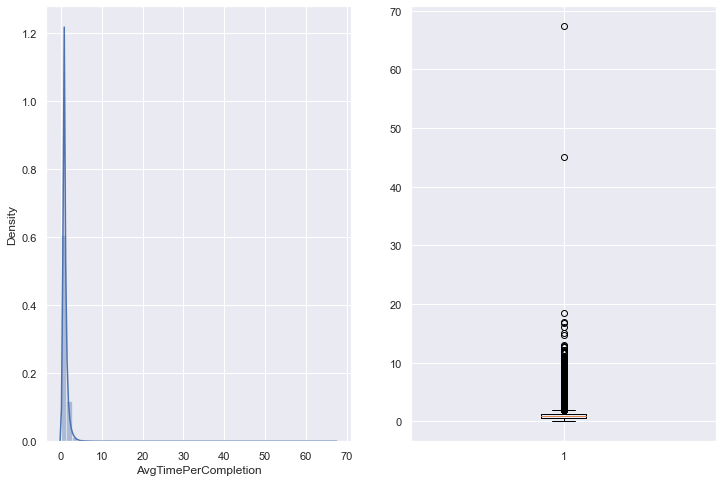

In [97]:
fc.continuous_analysis(data, 'AvgTimePerCompletion')

In [98]:
data['InteractionGeneral'] = data['TotalUsageTime'] * data['TotalRecords']

----- InteractionGeneral -----
count    1.589810e+05
mean     6.038133e+03
std      3.552264e+04
min      0.000000e+00
25%      2.502000e+01
50%      2.901600e+02
75%      2.182000e+03
max      4.699173e+06
Name: InteractionGeneral, dtype: float64
* Variance: 1261857992.3294597
* Median: 290.16
* Skewness: 37.11619946094764
* Kurtosis: 2995.4751820572733
* Percentage of outliers: 0.15316924663953554
* Number of missing value: 0


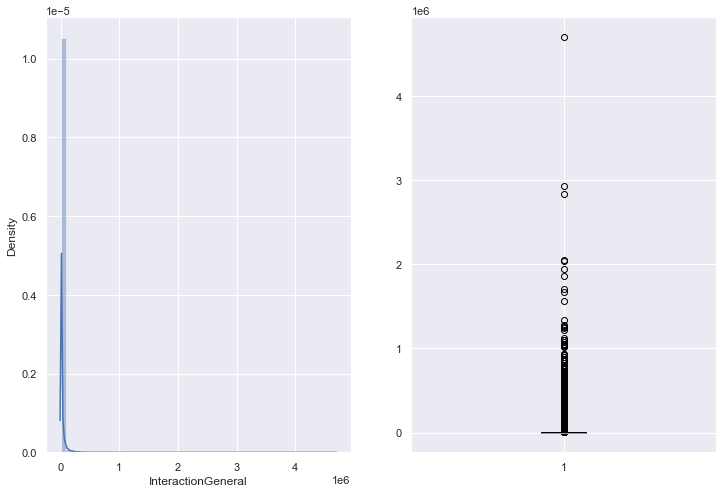

In [99]:
fc.continuous_analysis(data, 'InteractionGeneral')

In [100]:
data['Label'] = data['gapday'].map(lambda x: 1 if x <= 31 else 0)

In [101]:
data['Label'].value_counts()

0    148681
1     10300
Name: Label, dtype: int64

In [102]:
data1 = data.copy()

In [103]:
data = data.drop(['firstPaymentType', 'gapday', 'avgValue', 'Amount'], axis=1)
data.shape

(158981, 42)

----- Recency -----
count    158981.000000
mean          1.649549
std           0.477113
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max           2.000000
Name: Recency, dtype: float64
* Variance: 0.22763643356760838
* Median: 2.0
* Skewness: -0.6269010645512048
* Kurtosis: -1.6070152718672073
* Percentage of outliers: 0.0
* Number of missing value: 0


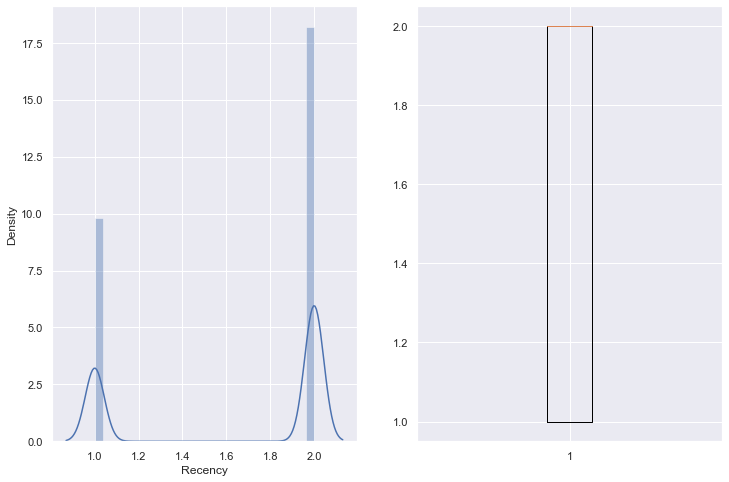


----- ContentFrequent -----
count    158981.000000
mean          2.070474
std           1.277692
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max           6.000000
Name: ContentFrequent, dtype: float64
* Variance: 1.6324972399444617
* Median: 2.0
* Skewness: 1.1571838071213179
* Kurtosis: 0.6323380501638809
* Percentage of outliers: 0.0
* Number of missing value: 0


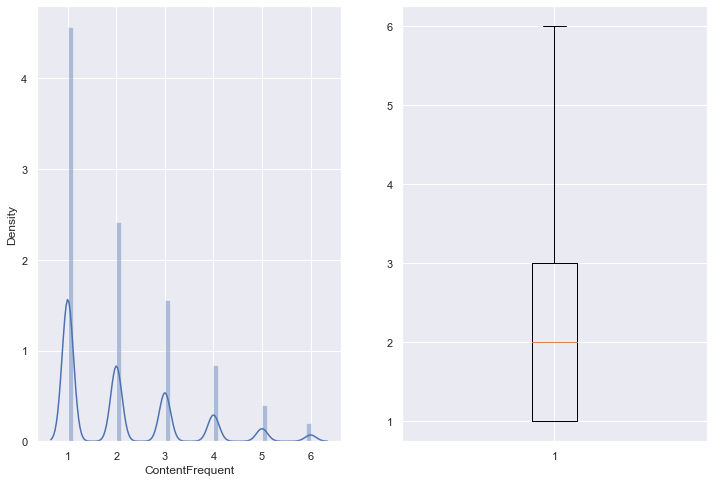


----- PaymentScreenFrequent -----
count    158981.000000
mean          7.049308
std          25.069770
min           0.000000
25%           0.000000
50%           0.000000
75%           4.000000
max        1668.000000
Name: PaymentScreenFrequent, dtype: float64
* Variance: 628.4933732313566
* Median: 0.0
* Skewness: 14.00179066483243
* Kurtosis: 410.4755987248835
* Percentage of outliers: 0.14959649266264521
* Number of missing value: 0


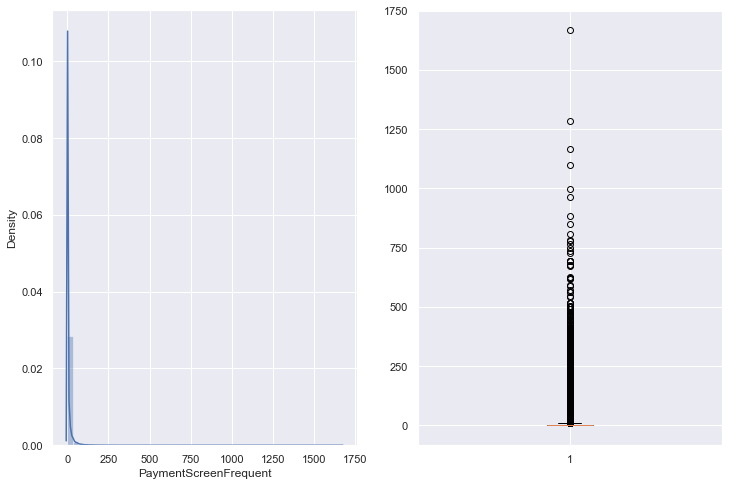


----- TotalUsageTime -----
count    158981.000000
mean         41.263432
std          72.001200
min           0.000000
25%           4.580000
50%          16.720000
75%          47.320000
max        3801.920000
Name: TotalUsageTime, dtype: float64
* Variance: 5184.172795135819
* Median: 16.72
* Skewness: 6.250745674835085
* Kurtosis: 109.9820563643665
* Percentage of outliers: 0.09310546543297626
* Number of missing value: 0


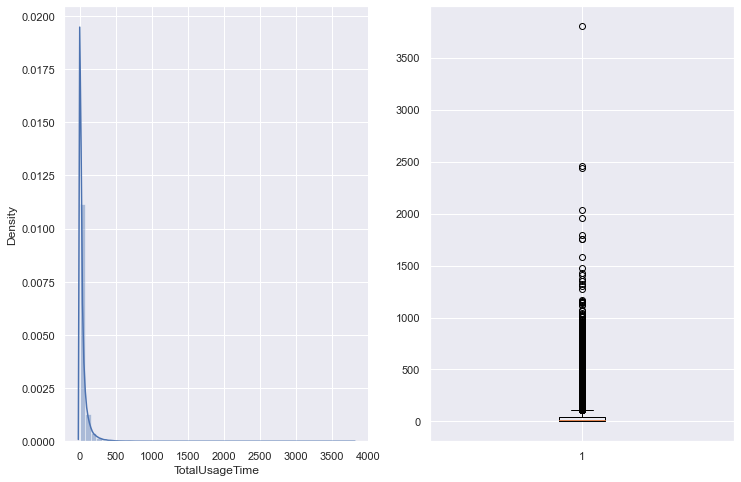


----- TotalRecords -----
count    158981.000000
mean         40.370044
std          66.341528
min           1.000000
25%           5.000000
50%          18.000000
75%          48.000000
max        1634.000000
Name: TotalRecords, dtype: float64
* Variance: 4401.198379032514
* Median: 18.0
* Skewness: 4.880352807149868
* Kurtosis: 42.94911240158537
* Percentage of outliers: 0.0848340367716897
* Number of missing value: 0


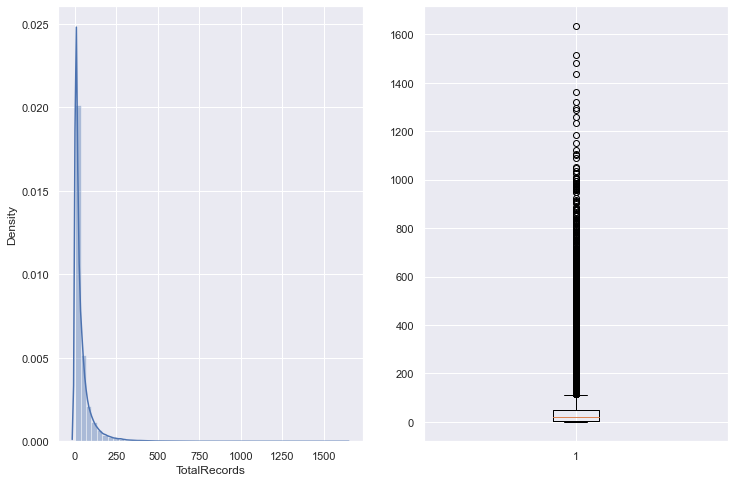


----- TotalChild -----
count    158981.000000
mean          1.064781
std           0.300394
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           4.000000
Name: TotalChild, dtype: float64
* Variance: 0.09023661544094125
* Median: 1.0
* Skewness: 5.6286414786703665
* Kurtosis: 37.57541573053112
* Percentage of outliers: 0.052729571458224565
* Number of missing value: 0


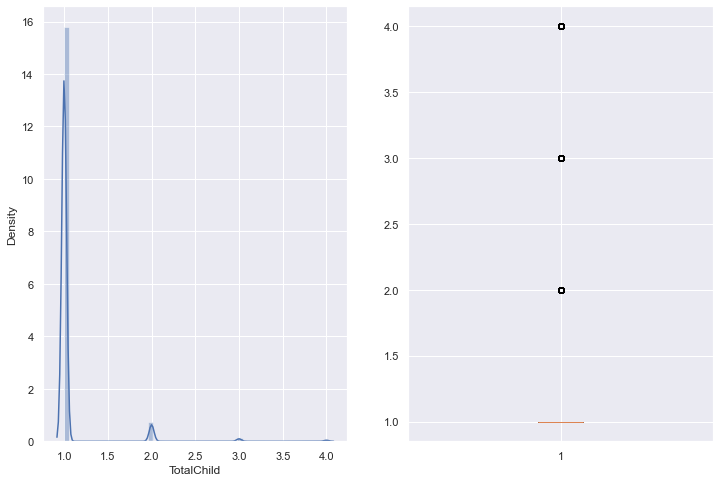


----- MedianChildAge -----
count    158981.000000
mean          5.625380
std           2.214603
min           0.000000
25%           4.300000
50%           5.500000
75%           6.900000
max          13.300000
Name: MedianChildAge, dtype: float64
* Variance: 4.90446587697089
* Median: 5.5
* Skewness: 0.549755334190111
* Kurtosis: 0.9948517573982323
* Percentage of outliers: 0.03180254244217862
* Number of missing value: 0


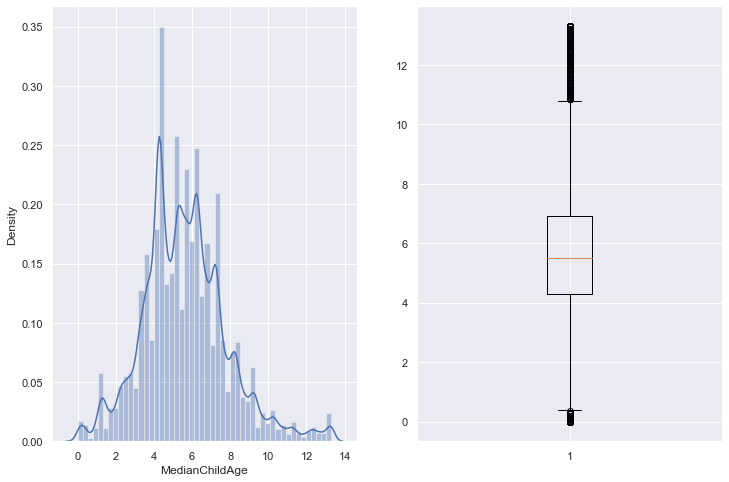


----- No.Female -----
count    158981.000000
mean          0.393192
std           0.519839
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           4.000000
Name: No.Female, dtype: float64
* Variance: 0.27023267474101703
* Median: 0.0
* Skewness: 0.8596115043080221
* Kurtosis: 0.12848452319862202
* Percentage of outliers: 0.0013901032198816211
* Number of missing value: 0


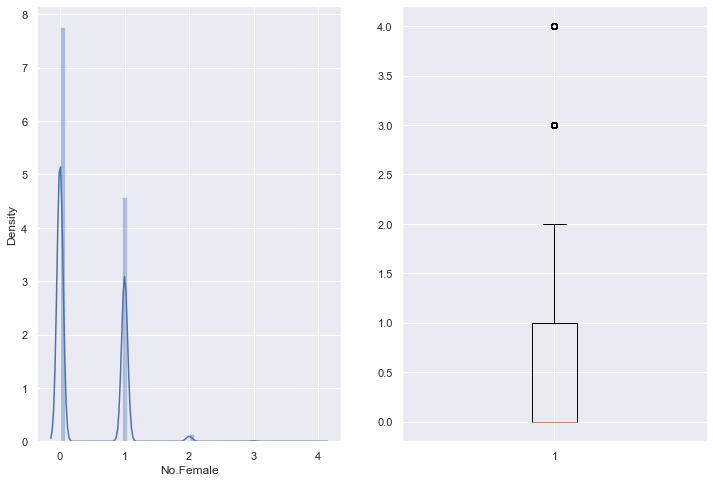


----- No.Male -----
count    158981.000000
mean          0.671590
std           0.542637
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           4.000000
Name: No.Male, dtype: float64
* Variance: 0.29445445426123107
* Median: 1.0
* Skewness: 0.22073744121088584
* Kurtosis: 0.940441269088828
* Percentage of outliers: 0.0040004780445462036
* Number of missing value: 0


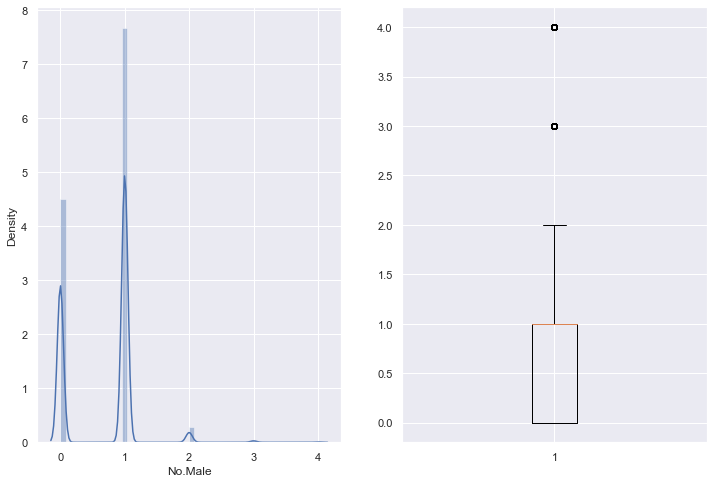


----- No.TypeBrand -----
count    158981.000000
mean          1.003548
std           0.059456
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           2.000000
Name: No.TypeBrand, dtype: float64
* Variance: 0.0035350305518429014
* Median: 1.0
* Skewness: 16.70000085603525
* Kurtosis: 276.8935119449272
* Percentage of outliers: 0.003547593737616445
* Number of missing value: 0


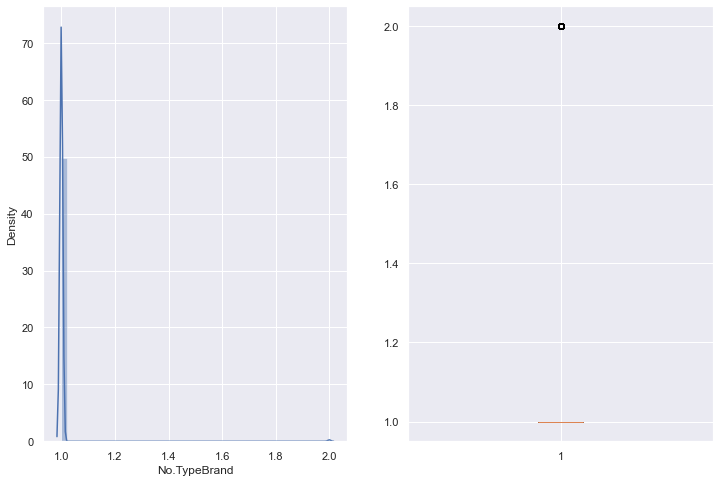


----- BigBrand -----
count    158981.000000
mean          2.551116
std           3.261146
min           0.000000
25%           0.000000
50%           2.000000
75%           4.000000
max          48.000000
Name: BigBrand, dtype: float64
* Variance: 10.63507267854721
* Median: 2.0
* Skewness: 2.4618814604169135
* Kurtosis: 9.03303522958249
* Percentage of outliers: 0.03272718123549355
* Number of missing value: 0


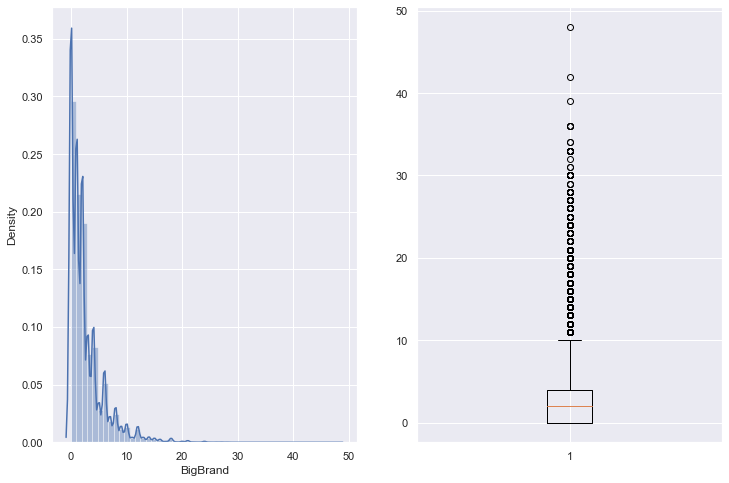


----- MediumBrand -----
count    158981.000000
mean          0.623779
std           1.956875
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          39.000000
Name: MediumBrand, dtype: float64
* Variance: 3.829358825557569
* Median: 0.0
* Skewness: 4.920202460590138
* Kurtosis: 32.494818517299024
* Percentage of outliers: 0.17099527616507634
* Number of missing value: 0


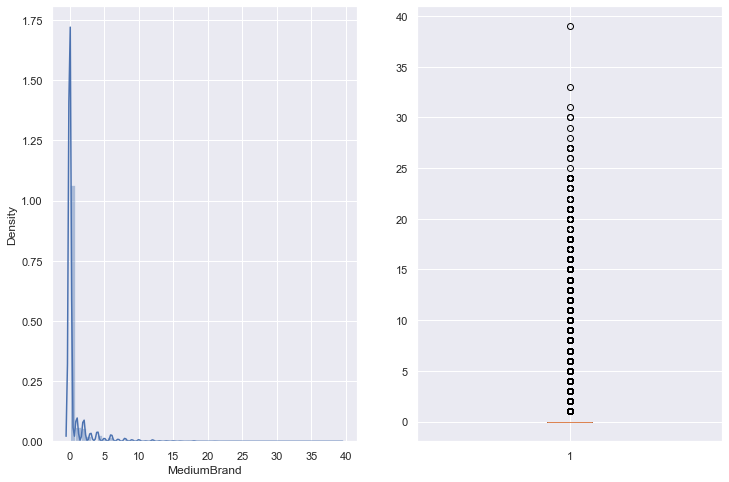


----- SmallBrand -----
count    158981.000000
mean          0.403061
std           1.530639
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          30.000000
Name: SmallBrand, dtype: float64
* Variance: 2.342856149467882
* Median: 0.0
* Skewness: 5.809630438123817
* Kurtosis: 44.738741886706435
* Percentage of outliers: 0.11630949610330794
* Number of missing value: 0


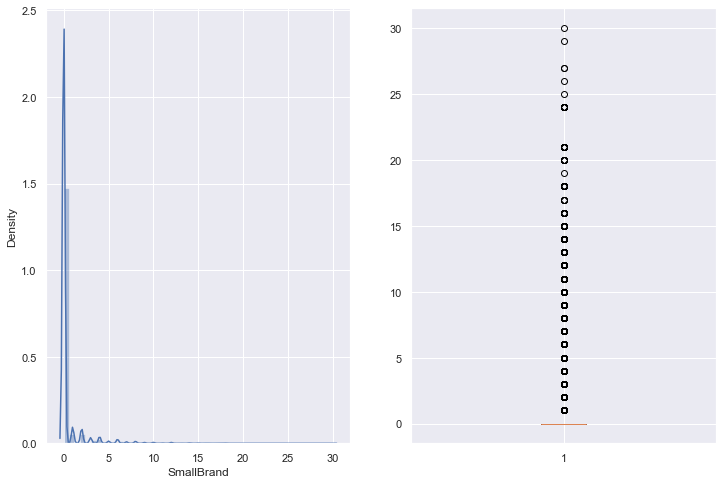


----- InteractionEnglish -----
count    158981.000000
mean        210.237728
std        1577.142563
min           0.000000
25%           0.000000
50%           0.610000
75%          72.940000
max      241076.340000
Name: InteractionEnglish, dtype: float64
* Variance: 2487378.664337131
* Median: 0.61
* Skewness: 82.15785764201567
* Kurtosis: 10487.385478852586
* Percentage of outliers: 0.1828017184443424
* Number of missing value: 0


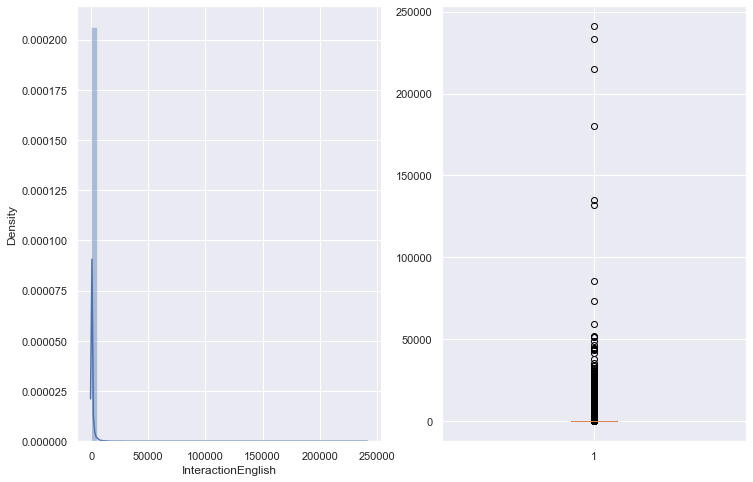


----- InteractionMath -----
count    158981.000000
mean          6.549885
std         212.458857
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       49013.400000
Name: InteractionMath, dtype: float64
* Variance: 45138.765851708995
* Median: 0.0
* Skewness: 110.02286687294016
* Kurtosis: 19873.079462014615
* Percentage of outliers: 0.02300903881595914
* Number of missing value: 0


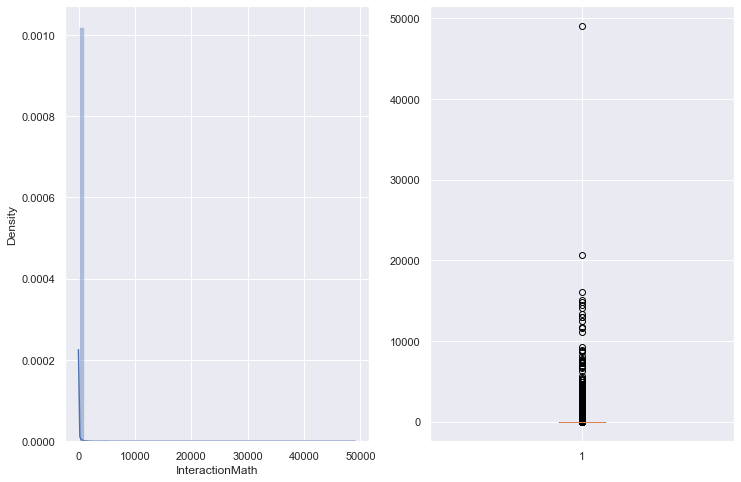


----- InteractionPhonics -----
count    158981.000000
mean          4.511953
std         104.635823
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       15501.780000
Name: InteractionPhonics, dtype: float64
* Variance: 10948.655488321421
* Median: 0.0
* Skewness: 64.88436054889843
* Kurtosis: 6335.667364820876
* Percentage of outliers: 0.023933677609274066
* Number of missing value: 0


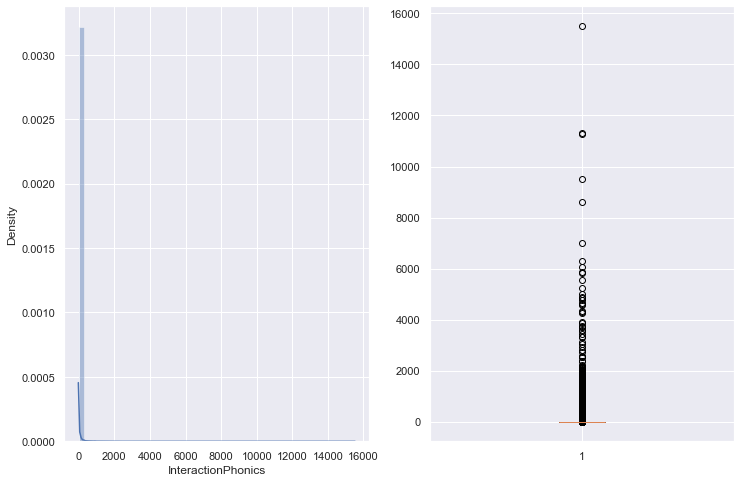


----- InteractionVietnamese -----
count    158981.000000
mean        337.194416
std        1828.476529
min           0.000000
25%           0.000000
50%           0.960000
75%          86.040000
max      192278.370000
Name: InteractionVietnamese, dtype: float64
* Variance: 3343326.4186315797
* Median: 0.96
* Skewness: 31.799854437083216
* Kurtosis: 2193.3239673280677
* Percentage of outliers: 0.18207836156521848
* Number of missing value: 0


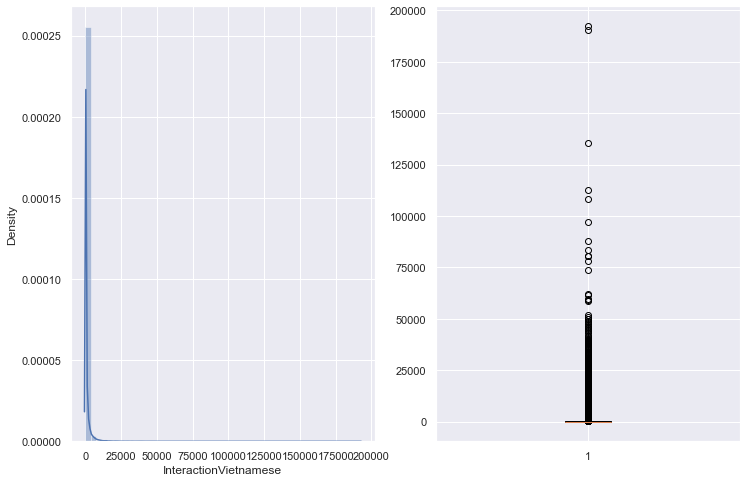


----- IsCompletedEnglish -----
count    158981.000000
mean          0.997786
std           1.323779
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max           6.000000
Name: IsCompletedEnglish, dtype: float64
* Variance: 1.7523916255908183
* Median: 0.0
* Skewness: 1.4671729893082723
* Kurtosis: 1.8044216425766764
* Percentage of outliers: 0.00977475295790063
* Number of missing value: 0


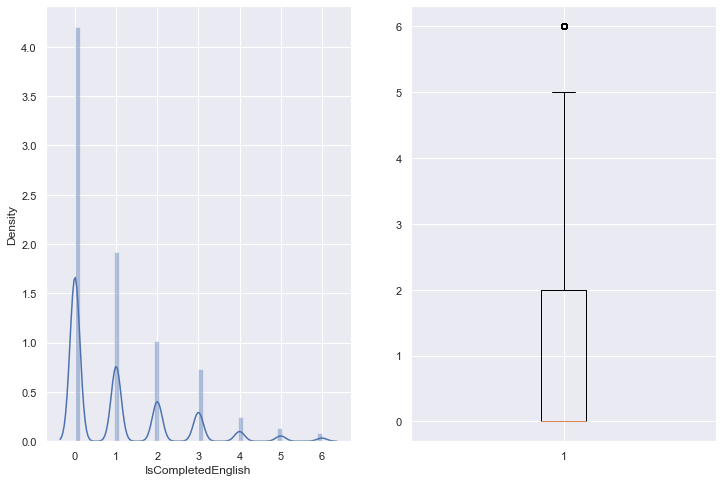


----- IsCompletedMath -----
count    158981.000000
mean          0.038967
std           0.306445
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           6.000000
Name: IsCompletedMath, dtype: float64
* Variance: 0.09390866729799542
* Median: 0.0
* Skewness: 9.884557104628003
* Kurtosis: 116.08266686809242
* Percentage of outliers: 0.02093331907586441
* Number of missing value: 0


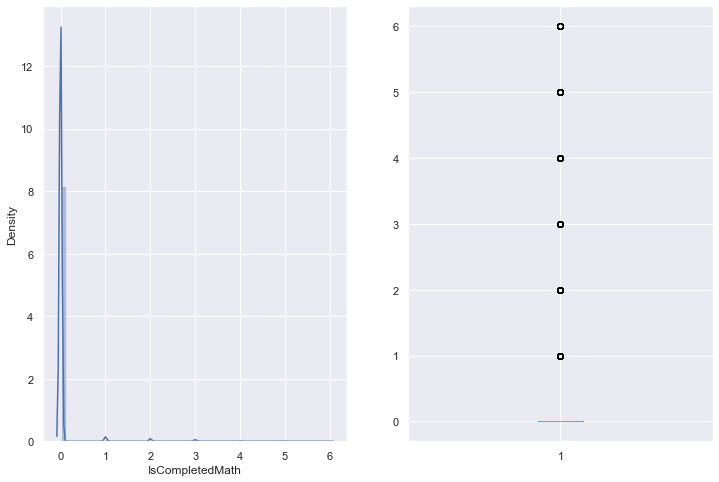


----- IsCompletedPhonics -----
count    158981.000000
mean          0.044672
std           0.341814
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           6.000000
Name: IsCompletedPhonics, dtype: float64
* Variance: 0.11683695698636247
* Median: 0.0
* Skewness: 9.341035400075683
* Kurtosis: 101.7121799325046
* Percentage of outliers: 0.02161893559607752
* Number of missing value: 0


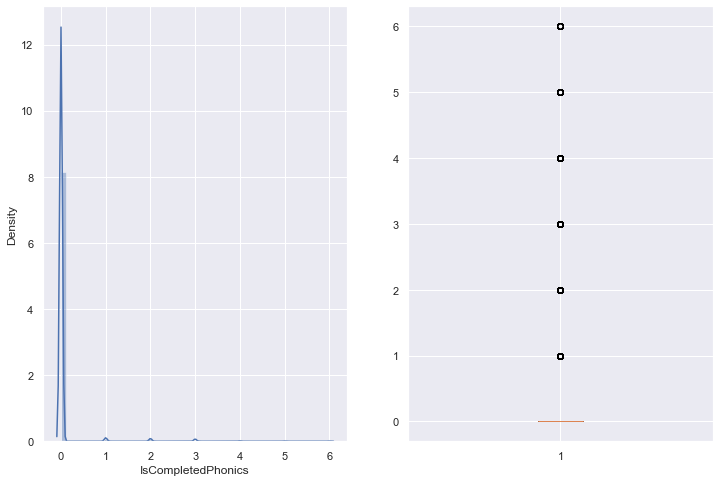


----- IsCompletedVietnamese -----
count    158981.000000
mean          1.043867
std           1.355188
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max           6.000000
Name: IsCompletedVietnamese, dtype: float64
* Variance: 1.8365333526140932
* Median: 1.0
* Skewness: 1.4054998756250245
* Kurtosis: 1.5606431047902727
* Percentage of outliers: 0.010894383605588089
* Number of missing value: 0


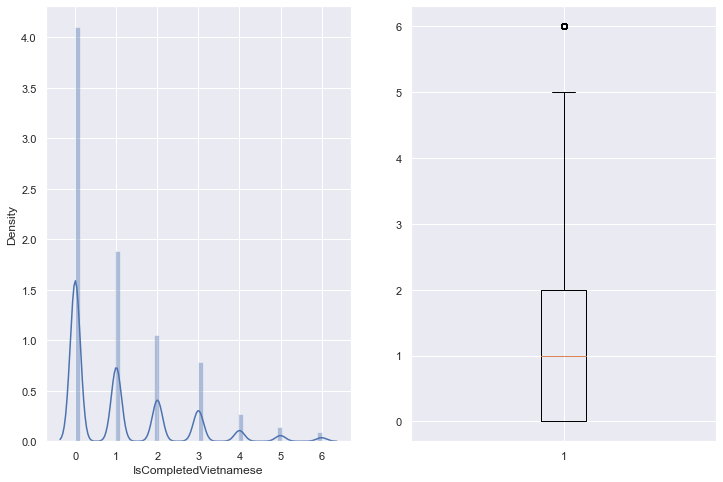


----- RecordEnglish -----
count    158981.000000
mean         13.068750
std          28.947499
min           0.000000
25%           0.000000
50%           1.000000
75%          14.000000
max         951.000000
Name: RecordEnglish, dtype: float64
* Variance: 837.9576963054019
* Median: 1.0
* Skewness: 5.601945111378728
* Kurtosis: 61.32595332722216
* Percentage of outliers: 0.11683786112805933
* Number of missing value: 0


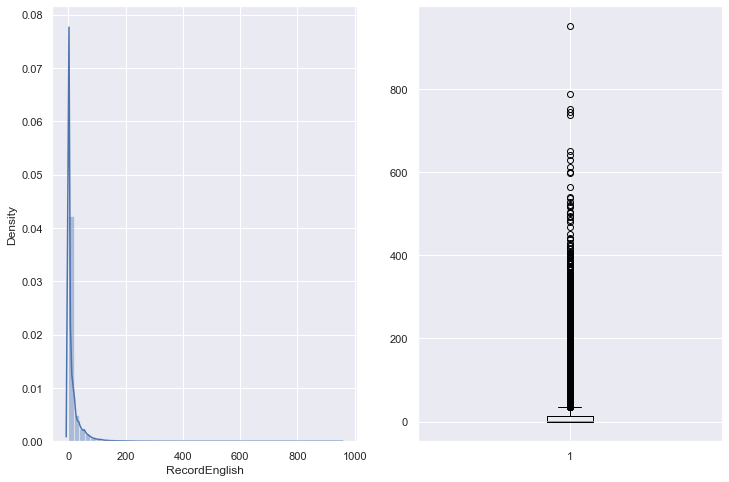


----- RecordMath -----
count    158981.000000
mean          0.320214
std           3.729954
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         345.000000
Name: RecordMath, dtype: float64
* Variance: 13.912558353845972
* Median: 0.0
* Skewness: 24.305551819393393
* Kurtosis: 998.506896621707
* Percentage of outliers: 0.023027908995414546
* Number of missing value: 0


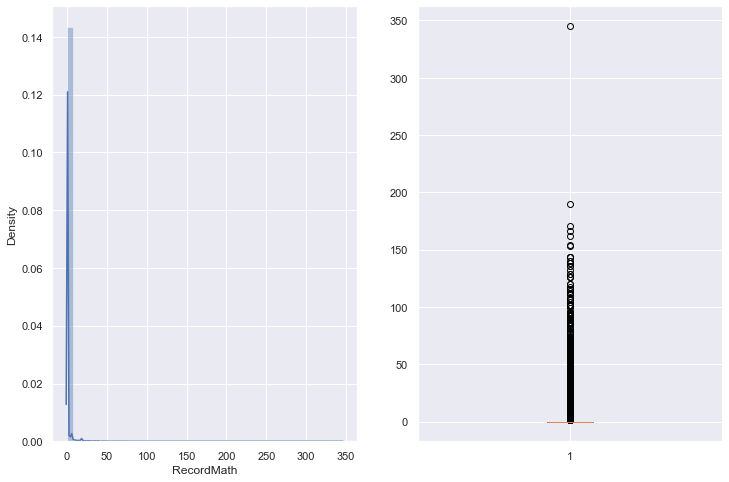


----- RecordPhonics -----
count    158981.000000
mean          0.342966
std           3.800804
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         291.000000
Name: RecordPhonics, dtype: float64
* Variance: 14.446111495030193
* Median: 0.0
* Skewness: 22.647053531519305
* Kurtosis: 809.6466747703977
* Percentage of outliers: 0.02396512790836641
* Number of missing value: 0


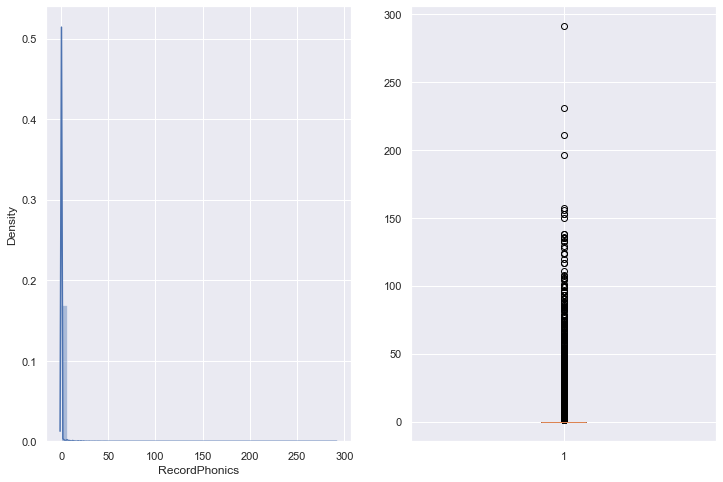


----- RecordVietnamese -----
count    158981.000000
mean         14.444613
std          33.592674
min           0.000000
25%           0.000000
50%           2.000000
75%          13.000000
max        1275.000000
Name: RecordVietnamese, dtype: float64
* Variance: 1128.4677414687358
* Median: 2.0
* Skewness: 5.520581415399147
* Kurtosis: 59.72503964114204
* Percentage of outliers: 0.13133015894981162
* Number of missing value: 0


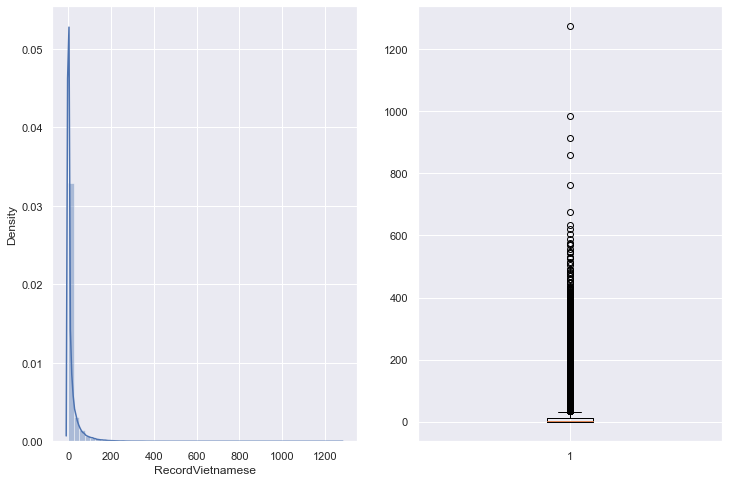


----- UsageTimeEnglish -----
count    158981.000000
mean          9.848296
std          25.708905
min           0.000000
25%           0.000000
50%           0.580000
75%           9.950000
max        2542.980000
Name: UsageTimeEnglish, dtype: float64
* Variance: 660.947783789081
* Median: 0.58
* Skewness: 19.355272950230855
* Kurtosis: 1267.3099387052896
* Percentage of outliers: 0.12023449343003252
* Number of missing value: 0


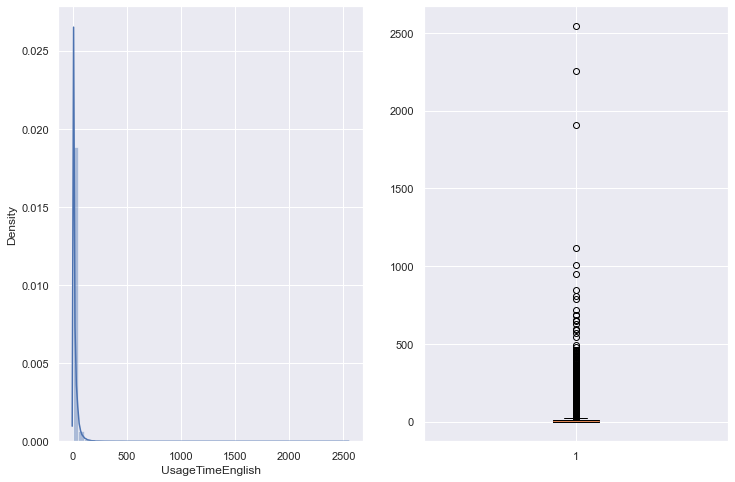


----- UsageTimeMath -----
count    158981.000000
mean          0.326643
std           5.076576
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         498.600000
Name: UsageTimeMath, dtype: float64
* Variance: 25.771626674860286
* Median: 0.0
* Skewness: 40.40154253199256
* Kurtosis: 2504.9607095474685
* Percentage of outliers: 0.02300903881595914
* Number of missing value: 0


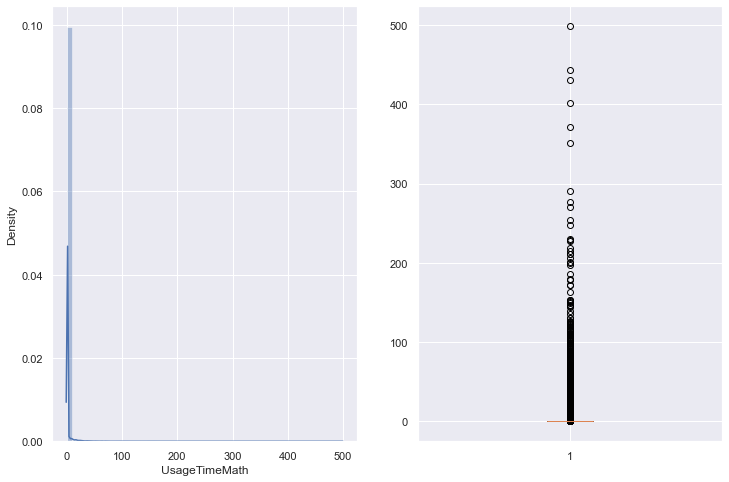


----- UsageTimePhonics -----
count    158981.000000
mean          0.325280
std           3.674106
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         257.460000
Name: UsageTimePhonics, dtype: float64
* Variance: 13.499057939745317
* Median: 0.0
* Skewness: 22.529454943466497
* Kurtosis: 764.2098891465741
* Percentage of outliers: 0.023933677609274066
* Number of missing value: 0


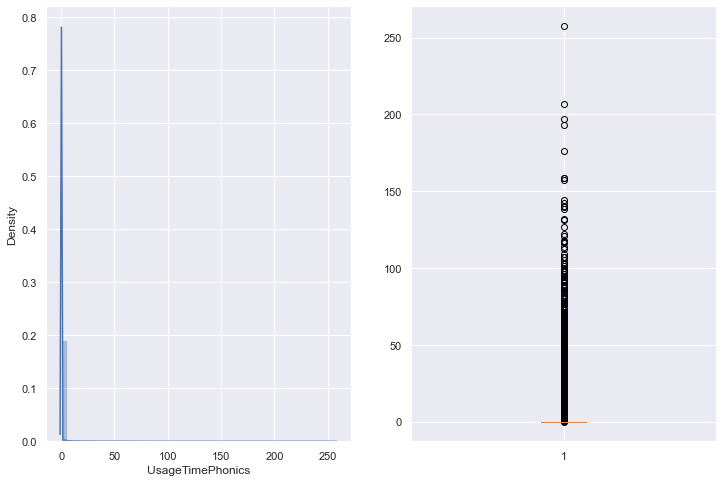


----- UsageTimeVietnamese -----
count    158981.000000
mean         12.817580
std          29.626057
min           0.000000
25%           0.000000
50%           0.850000
75%          12.280000
max        1505.640000
Name: UsageTimeVietnamese, dtype: float64
* Variance: 877.703237404453
* Median: 0.8500000000000001
* Skewness: 5.9472847376332
* Kurtosis: 89.00367651885706
* Percentage of outliers: 0.1274554821016348
* Number of missing value: 0


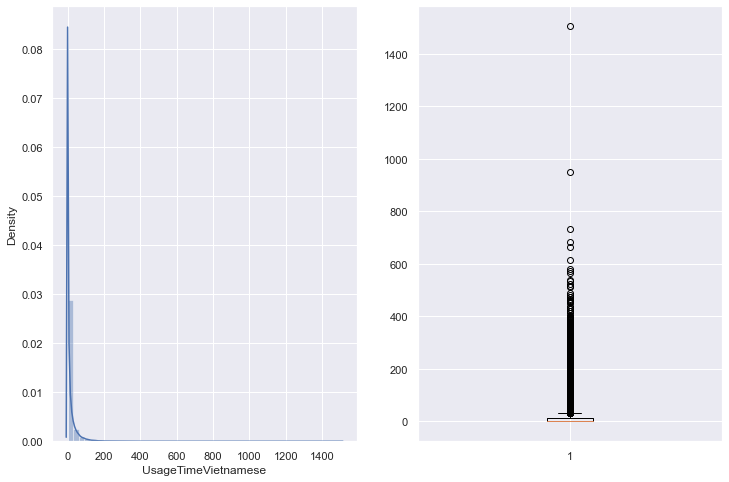


----- RecordDiscovery -----
count    158981.000000
mean          2.831238
std           7.300165
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max         265.000000
Name: RecordDiscovery, dtype: float64
* Variance: 53.29240223524181
* Median: 0.0
* Skewness: 5.812629674284027
* Kurtosis: 65.56776640939844
* Percentage of outliers: 0.15521351608053793
* Number of missing value: 0


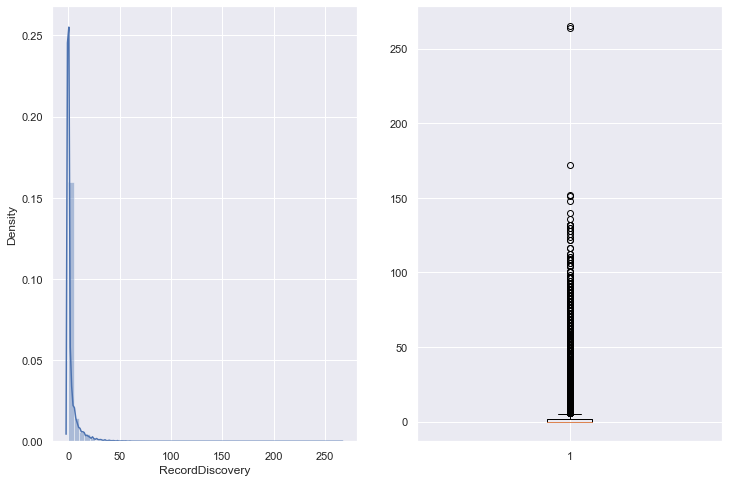


----- RecordEntertainment -----
count    158981.000000
mean          4.127009
std          12.740473
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max         516.000000
Name: RecordEntertainment, dtype: float64
* Variance: 162.3196467262325
* Median: 0.0
* Skewness: 9.05202980329105
* Kurtosis: 153.11245481569657
* Percentage of outliers: 0.14530667186644944
* Number of missing value: 0


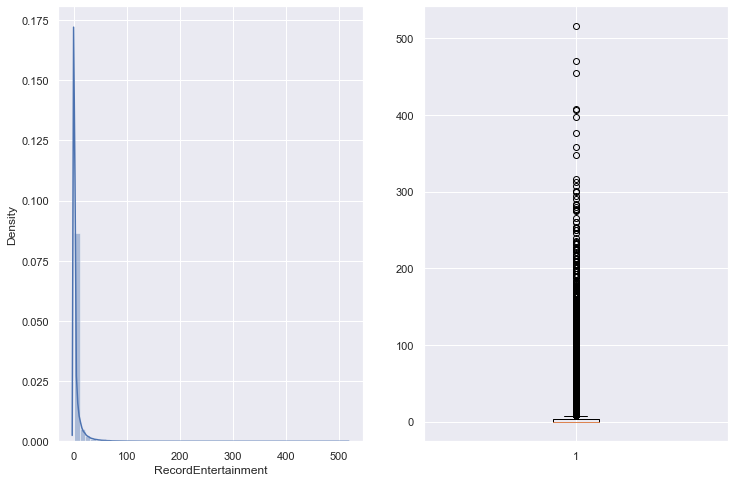


----- RecordLearn -----
count    158981.000000
mean         33.411798
std          57.699403
min           0.000000
25%           4.000000
50%          14.000000
75%          40.000000
max        1434.000000
Name: RecordLearn, dtype: float64
* Variance: 3329.2211122930785
* Median: 14.0
* Skewness: 5.2529324044101475
* Kurtosis: 50.697739256188925
* Percentage of outliers: 0.08359489498745133
* Number of missing value: 0


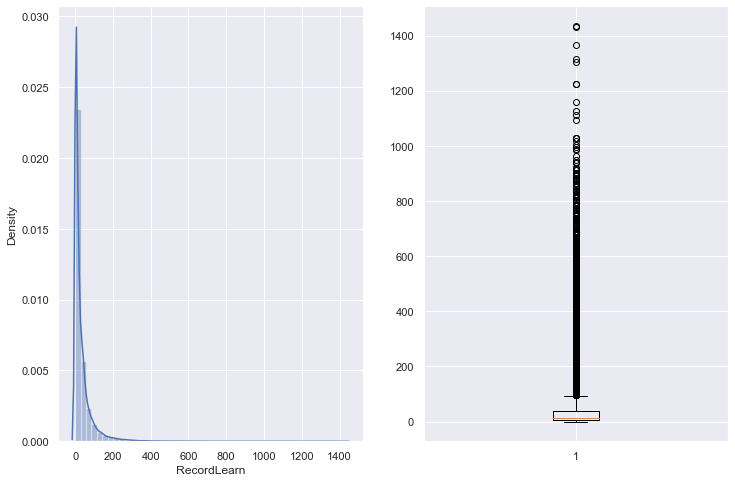


----- UsageTimeDiscovery -----
count    158981.000000
mean          6.198132
std          16.931101
min           0.000000
25%           0.000000
50%           0.000000
75%           3.640000
max         473.580000
Name: UsageTimeDiscovery, dtype: float64
* Variance: 286.6621934046628
* Median: 0.0
* Skewness: 5.620541007689153
* Kurtosis: 53.27361561820098
* Percentage of outliers: 0.17358049075046703
* Number of missing value: 0


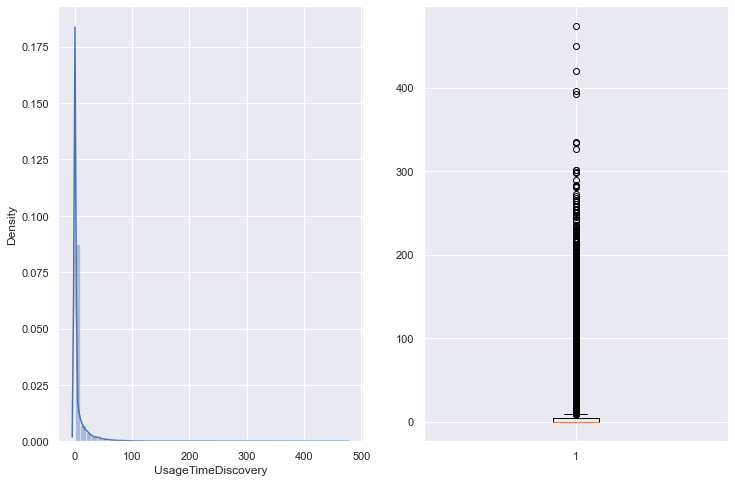


----- UsageTimeEntertainment -----
count    158981.000000
mean          7.450929
std          26.415610
min           0.000000
25%           0.000000
50%           0.000000
75%           2.360000
max        1605.600000
Name: UsageTimeEntertainment, dtype: float64
* Variance: 697.7844661238736
* Median: 0.0
* Skewness: 10.551088106966708
* Kurtosis: 269.1746359829052
* Percentage of outliers: 0.1875129732483756
* Number of missing value: 0


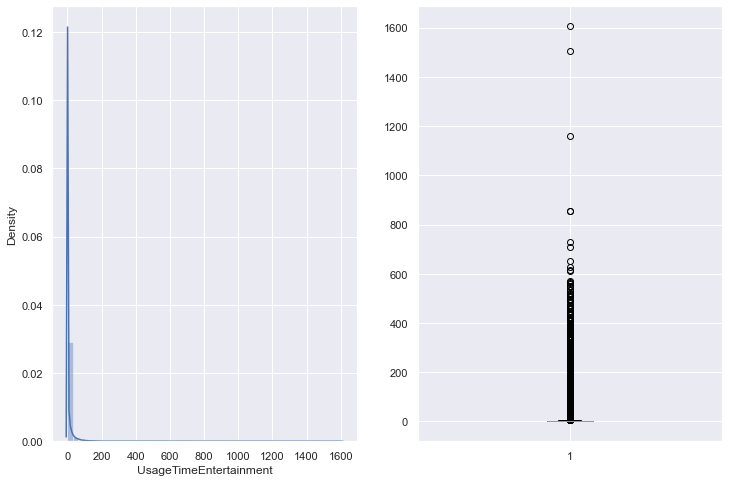


----- UsageTimeLearn -----
count    158981.000000
mean         27.614372
std          51.724071
min           0.000000
25%           2.680000
50%          11.060000
75%          31.800000
max        3585.040000
Name: UsageTimeLearn, dtype: float64
* Variance: 2675.379522600764
* Median: 11.06
* Skewness: 8.793541087723147
* Kurtosis: 252.95321416709282
* Percentage of outliers: 0.0881677684754782
* Number of missing value: 0


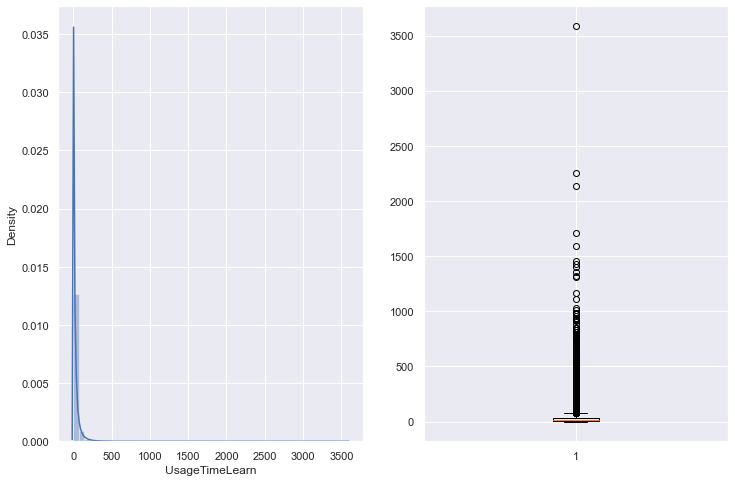


----- MedianUsageTime -----
count    158981.000000
mean          8.712814
std           9.770319
min           0.000000
25%           2.350000
50%           5.835000
75%          11.930000
max         442.680000
Name: MedianUsageTime, dtype: float64
* Variance: 95.45912548485862
* Median: 5.835
* Skewness: 4.217593918740987
* Kurtosis: 58.565085536858376
* Percentage of outliers: 0.04669111403249445
* Number of missing value: 0


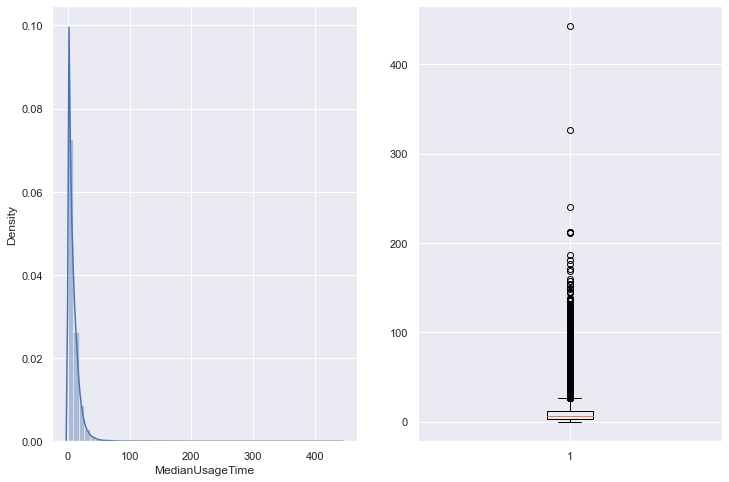


----- MedianRecord -----
count    158981.000000
mean          8.690252
std           9.697100
min           1.000000
25%           3.000000
50%           5.500000
75%          11.000000
max         208.000000
Name: MedianRecord, dtype: float64
* Variance: 94.03375445955763
* Median: 5.5
* Skewness: 3.4412590612182603
* Kurtosis: 23.536700415027138
* Percentage of outliers: 0.06622803982865877
* Number of missing value: 0


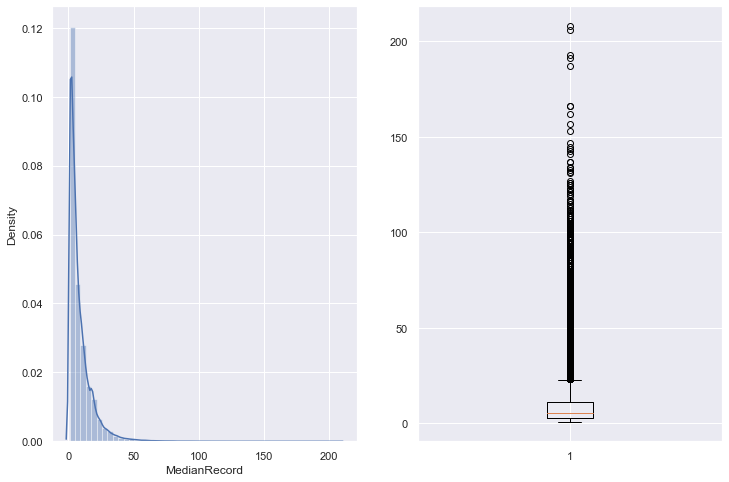


----- MedianPaymentScreen -----
count    158981.000000
mean          1.289132
std           3.093620
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         182.000000
Name: MedianPaymentScreen, dtype: float64
* Variance: 9.570482842681221
* Median: 0.0
* Skewness: 7.843326030903125
* Kurtosis: 159.46660397114644
* Percentage of outliers: 0.1544335486630478
* Number of missing value: 0


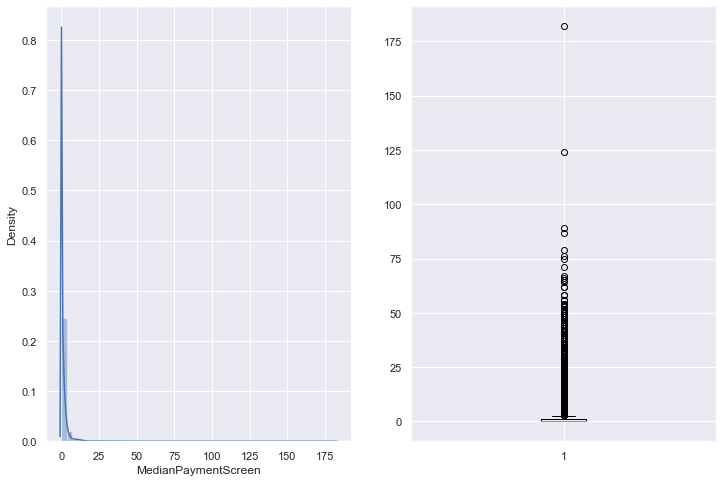


----- AvgTimePerCompletion -----
count    158981.000000
mean          1.024585
std           0.685115
min           0.000000
25%           0.675000
50%           0.867692
75%           1.190909
max          67.370000
Name: AvgTimePerCompletion, dtype: float64
* Variance: 0.46938317014335856
* Median: 0.8676923076923078
* Skewness: 10.99681967440362
* Kurtosis: 694.0463046153554
* Percentage of outliers: 0.06500776822387581
* Number of missing value: 0


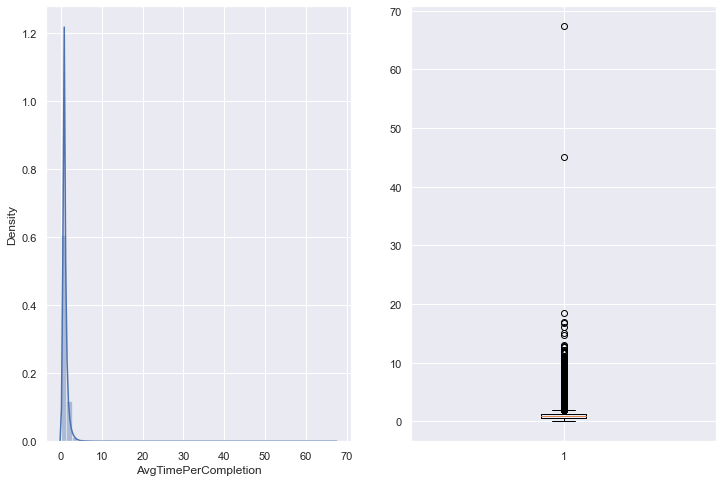


----- InteractionGeneral -----
count    1.589810e+05
mean     6.038133e+03
std      3.552264e+04
min      0.000000e+00
25%      2.502000e+01
50%      2.901600e+02
75%      2.182000e+03
max      4.699173e+06
Name: InteractionGeneral, dtype: float64
* Variance: 1261857992.3294597
* Median: 290.16
* Skewness: 37.11619946094764
* Kurtosis: 2995.4751820572733
* Percentage of outliers: 0.15316924663953554
* Number of missing value: 0


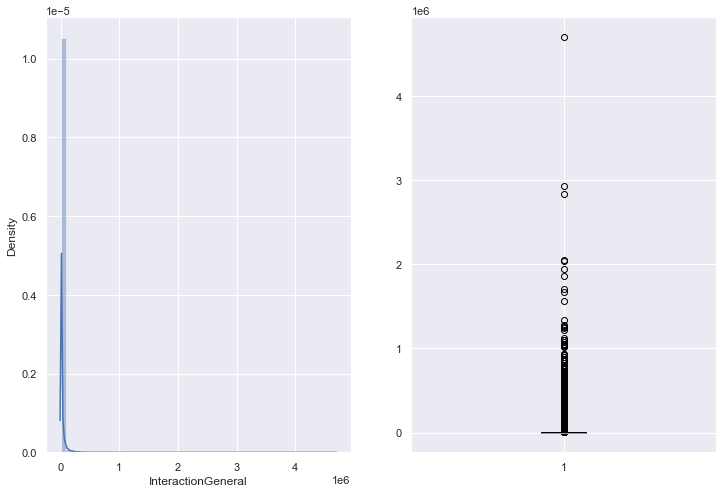


----- Label -----
count    158981.000000
mean          0.064788
std           0.246152
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Label, dtype: float64
* Variance: 0.06059056204465114
* Median: 0.0
* Skewness: 3.5361787763973265
* Kurtosis: 10.504692488772895
* Percentage of outliers: 0.0647876161302294
* Number of missing value: 0


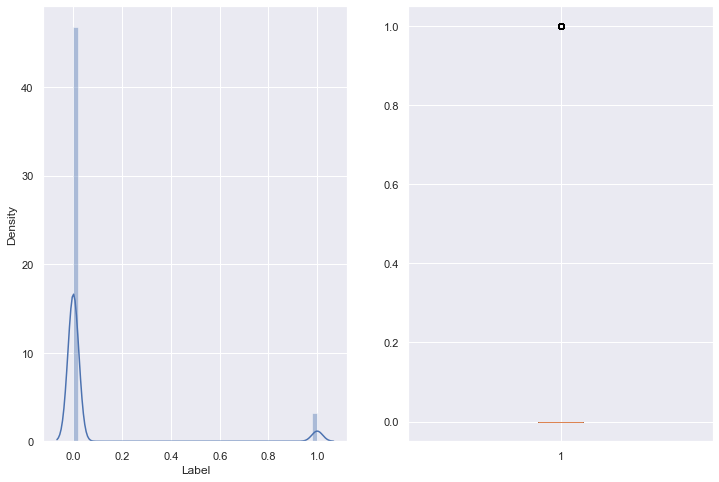

In [83]:
for col in data.columns[1:]:
    fc.continuous_analysis(data, col)

In [84]:
data.columns

Index(['UserID', 'Recency', 'ContentFrequent', 'PaymentScreenFrequent',
       'TotalUsageTime', 'TotalRecords', 'TotalChild', 'MedianChildAge',
       'No.Female', 'No.Male', 'No.TypeBrand', 'BigBrand', 'MediumBrand',
       'SmallBrand', 'InteractionEnglish', 'InteractionMath',
       'InteractionPhonics', 'InteractionVietnamese', 'IsCompletedEnglish',
       'IsCompletedMath', 'IsCompletedPhonics', 'IsCompletedVietnamese',
       'RecordEnglish', 'RecordMath', 'RecordPhonics', 'RecordVietnamese',
       'UsageTimeEnglish', 'UsageTimeMath', 'UsageTimePhonics',
       'UsageTimeVietnamese', 'RecordDiscovery', 'RecordEntertainment',
       'RecordLearn', 'UsageTimeDiscovery', 'UsageTimeEntertainment',
       'UsageTimeLearn', 'MedianUsageTime', 'MedianRecord',
       'MedianPaymentScreen', 'AvgTimePerCompletion', 'InteractionGeneral',
       'Label'],
      dtype='object')

In [104]:
excludes = ['Recency', 'ContentFrequent', 'PaymentScreenFrequent', 'TotalChild', 'MedianChildAge',
       'No.Female', 'No.Male', 'No.TypeBrand', 'BigBrand', 'MediumBrand',
       'SmallBrand', 'Label']

In [105]:
for col in data.columns[1:]:
    if col not in excludes:
        if data[col].min() == 0:
            data[col] = data[col] + 1
            data[col] = np.log(data[col])
        else:
            data[col] = np.log(data[col])

----- Recency -----
count    158981.000000
mean          1.649549
std           0.477113
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max           2.000000
Name: Recency, dtype: float64
* Variance: 0.22763643356760838
* Median: 2.0
* Skewness: -0.6269010645512048
* Kurtosis: -1.6070152718672073
* Percentage of outliers: 0.0
* Number of missing value: 0


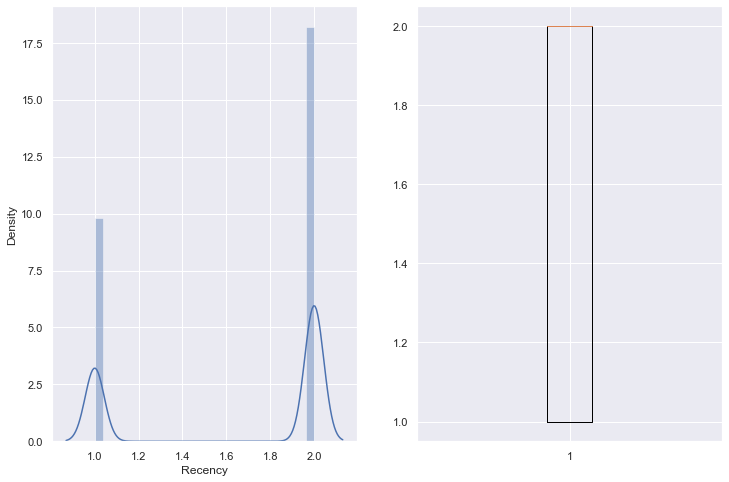


----- ContentFrequent -----
count    158981.000000
mean          2.070474
std           1.277692
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max           6.000000
Name: ContentFrequent, dtype: float64
* Variance: 1.6324972399444617
* Median: 2.0
* Skewness: 1.1571838071213179
* Kurtosis: 0.6323380501638809
* Percentage of outliers: 0.0
* Number of missing value: 0


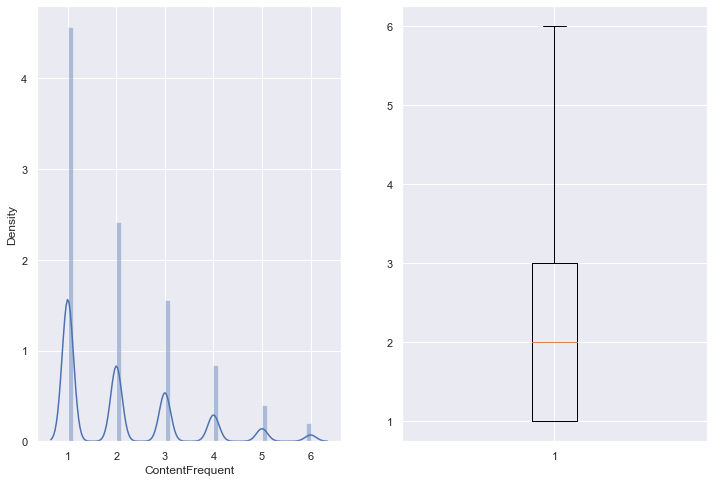


----- PaymentScreenFrequent -----
count    158981.000000
mean          7.049308
std          25.069770
min           0.000000
25%           0.000000
50%           0.000000
75%           4.000000
max        1668.000000
Name: PaymentScreenFrequent, dtype: float64
* Variance: 628.4933732313566
* Median: 0.0
* Skewness: 14.00179066483243
* Kurtosis: 410.4755987248835
* Percentage of outliers: 0.14959649266264521
* Number of missing value: 0


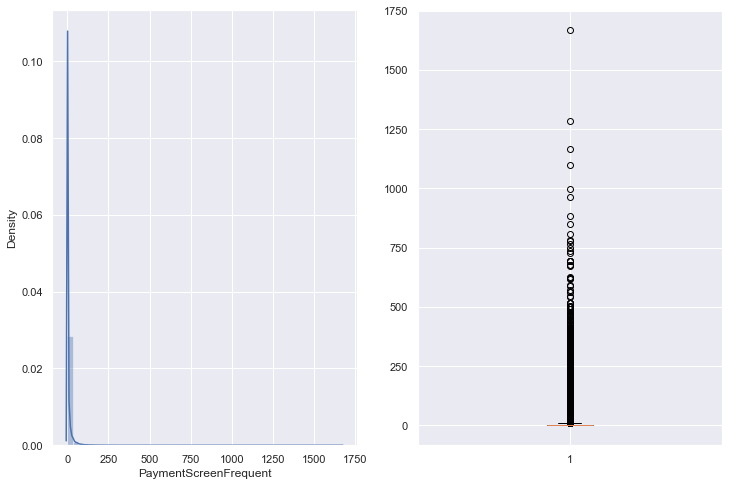


----- TotalUsageTime -----
count    158981.000000
mean          2.825583
std           1.410788
min           0.000000
25%           1.719189
50%           2.874694
75%           3.877846
max           8.243524
Name: TotalUsageTime, dtype: float64
* Variance: 1.9903216789372375
* Median: 2.8746939451769347
* Skewness: 0.02996671665501024
* Kurtosis: -0.7605086451898426
* Percentage of outliers: 0.00010693101691397086
* Number of missing value: 0


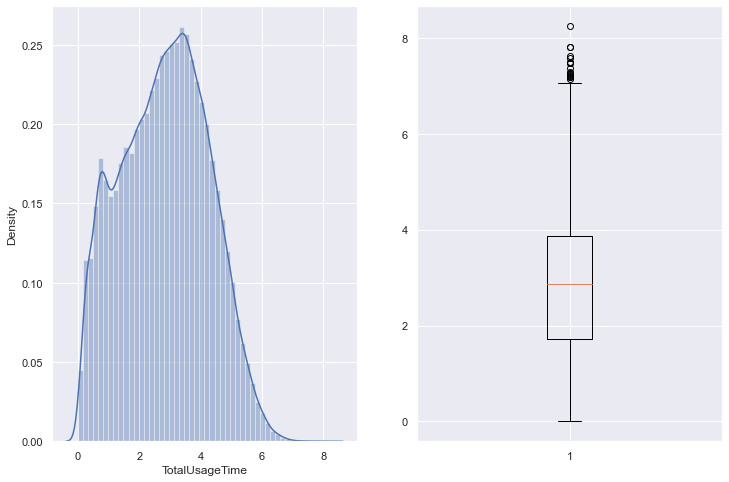


----- TotalRecords -----
count    158981.000000
mean          2.752861
std           1.483385
min           0.000000
25%           1.609438
50%           2.890372
75%           3.871201
max           7.398786
Name: TotalRecords, dtype: float64
* Variance: 2.2004319246150534
* Median: 2.8903717578961645
* Skewness: -0.15807489134406433
* Kurtosis: -0.6792609104402278
* Percentage of outliers: 2.5160239273875493e-05
* Number of missing value: 0


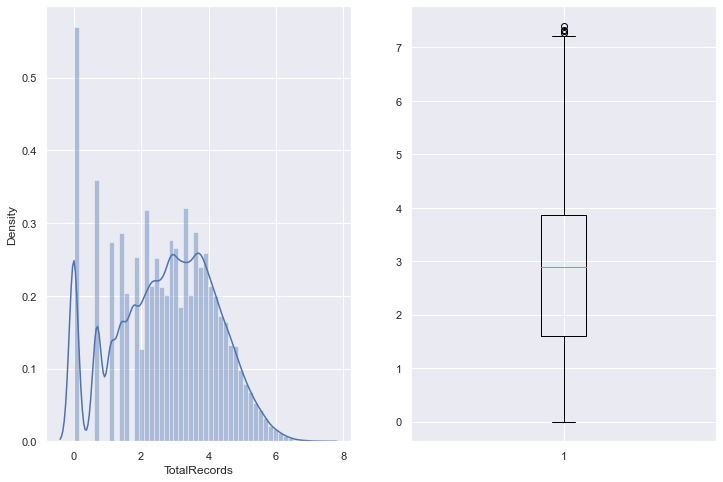


----- TotalChild -----
count    158981.000000
mean          1.064781
std           0.300394
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           4.000000
Name: TotalChild, dtype: float64
* Variance: 0.09023661544094125
* Median: 1.0
* Skewness: 5.6286414786703665
* Kurtosis: 37.57541573053112
* Percentage of outliers: 0.052729571458224565
* Number of missing value: 0


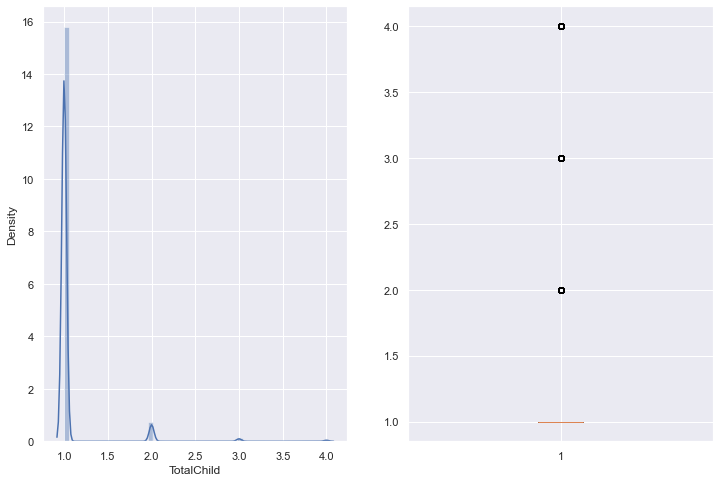


----- MedianChildAge -----
count    158981.000000
mean          5.625380
std           2.214603
min           0.000000
25%           4.300000
50%           5.500000
75%           6.900000
max          13.300000
Name: MedianChildAge, dtype: float64
* Variance: 4.90446587697089
* Median: 5.5
* Skewness: 0.549755334190111
* Kurtosis: 0.9948517573982323
* Percentage of outliers: 0.03180254244217862
* Number of missing value: 0


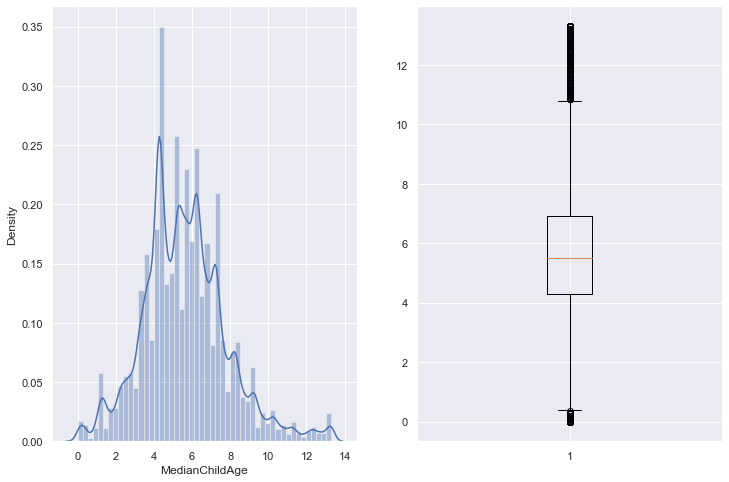


----- No.Female -----
count    158981.000000
mean          0.393192
std           0.519839
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           4.000000
Name: No.Female, dtype: float64
* Variance: 0.27023267474101703
* Median: 0.0
* Skewness: 0.8596115043080221
* Kurtosis: 0.12848452319862202
* Percentage of outliers: 0.0013901032198816211
* Number of missing value: 0


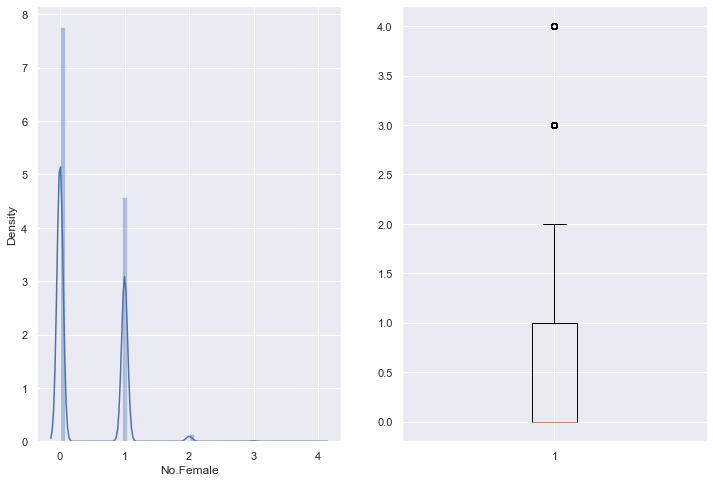


----- No.Male -----
count    158981.000000
mean          0.671590
std           0.542637
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           4.000000
Name: No.Male, dtype: float64
* Variance: 0.29445445426123107
* Median: 1.0
* Skewness: 0.22073744121088584
* Kurtosis: 0.940441269088828
* Percentage of outliers: 0.0040004780445462036
* Number of missing value: 0


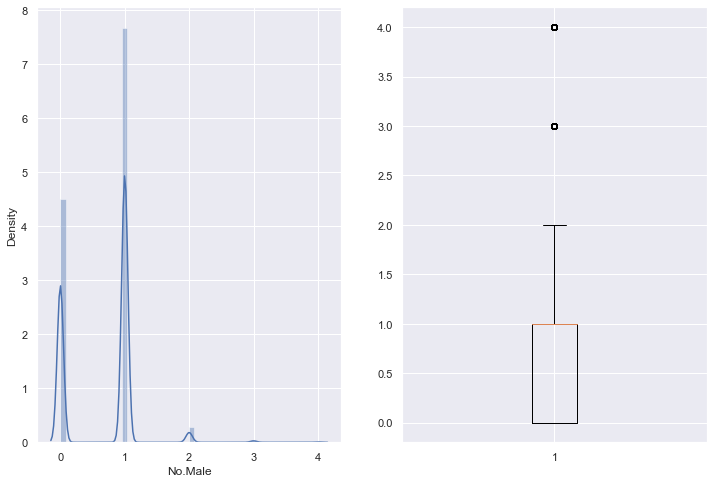


----- No.TypeBrand -----
count    158981.000000
mean          1.003548
std           0.059456
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           2.000000
Name: No.TypeBrand, dtype: float64
* Variance: 0.0035350305518429014
* Median: 1.0
* Skewness: 16.70000085603525
* Kurtosis: 276.8935119449272
* Percentage of outliers: 0.003547593737616445
* Number of missing value: 0


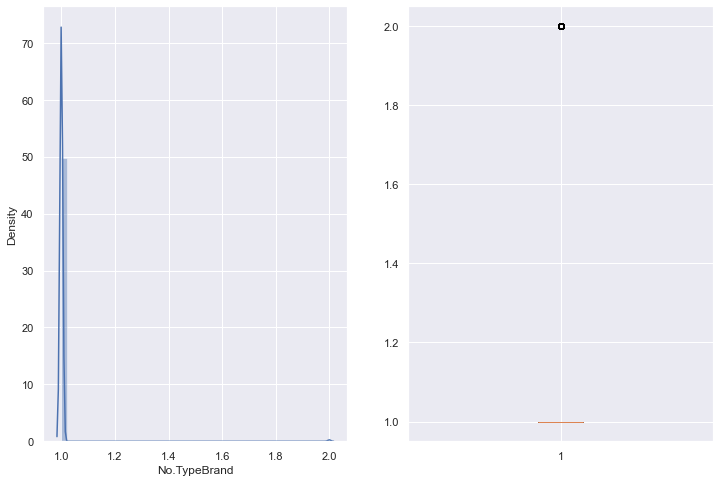


----- BigBrand -----
count    158981.000000
mean          2.551116
std           3.261146
min           0.000000
25%           0.000000
50%           2.000000
75%           4.000000
max          48.000000
Name: BigBrand, dtype: float64
* Variance: 10.63507267854721
* Median: 2.0
* Skewness: 2.4618814604169135
* Kurtosis: 9.03303522958249
* Percentage of outliers: 0.03272718123549355
* Number of missing value: 0


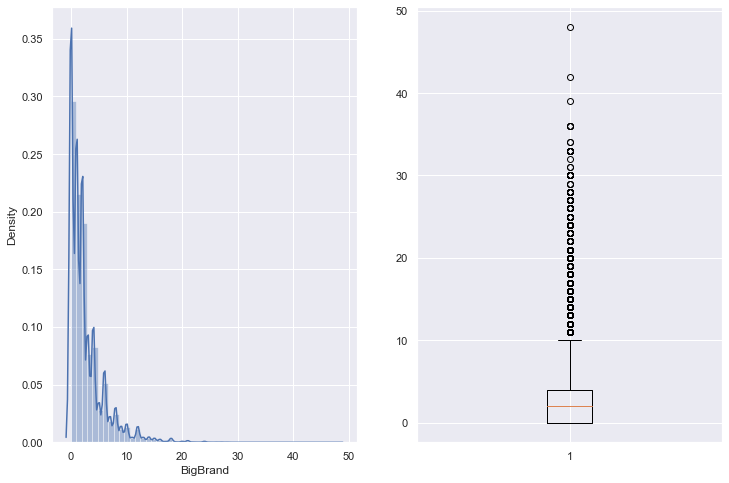


----- MediumBrand -----
count    158981.000000
mean          0.623779
std           1.956875
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          39.000000
Name: MediumBrand, dtype: float64
* Variance: 3.829358825557569
* Median: 0.0
* Skewness: 4.920202460590138
* Kurtosis: 32.494818517299024
* Percentage of outliers: 0.17099527616507634
* Number of missing value: 0


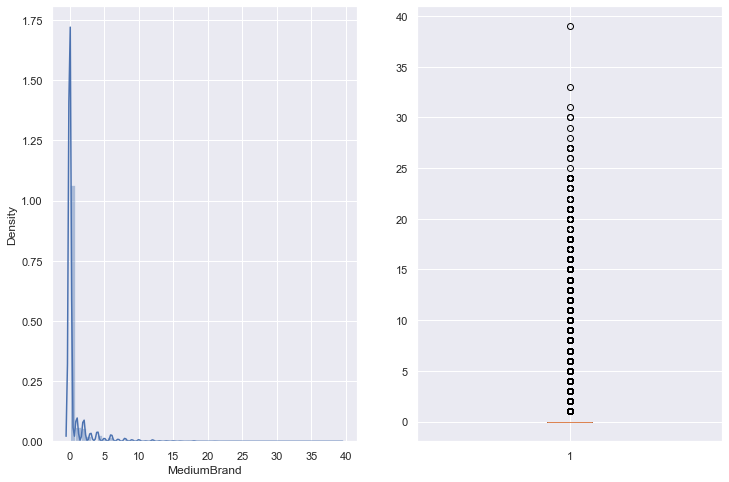


----- SmallBrand -----
count    158981.000000
mean          0.403061
std           1.530639
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          30.000000
Name: SmallBrand, dtype: float64
* Variance: 2.342856149467882
* Median: 0.0
* Skewness: 5.809630438123817
* Kurtosis: 44.738741886706435
* Percentage of outliers: 0.11630949610330794
* Number of missing value: 0


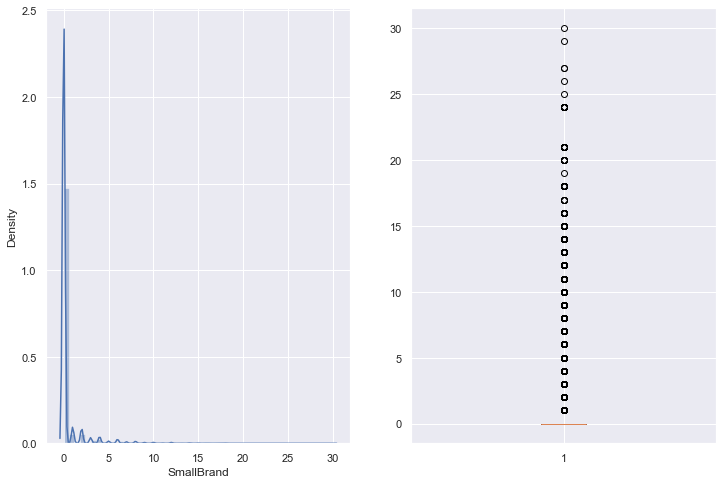


----- InteractionEnglish -----
count    158981.000000
mean          2.095570
std           2.552448
min           0.000000
25%           0.000000
50%           0.476234
75%           4.303254
max          12.392873
Name: InteractionEnglish, dtype: float64
* Variance: 6.514992617380857
* Median: 0.47623417899637155
* Skewness: 0.810660181201602
* Kurtosis: -0.7572271630907248
* Percentage of outliers: 8.177077764009535e-05
* Number of missing value: 0


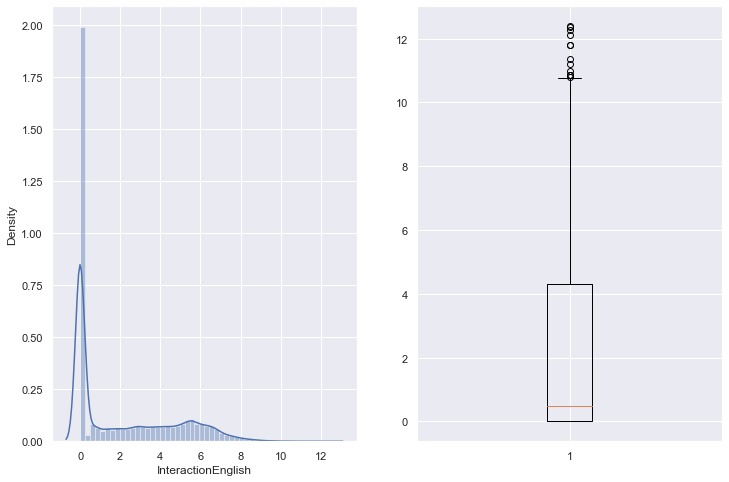


----- InteractionMath -----
count    158981.000000
mean          0.070474
std           0.573393
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          10.799869
Name: InteractionMath, dtype: float64
* Variance: 0.32877962437502234
* Median: 0.0
* Skewness: 9.576093976860893
* Kurtosis: 99.62178219553283
* Percentage of outliers: 0.02300903881595914
* Number of missing value: 0


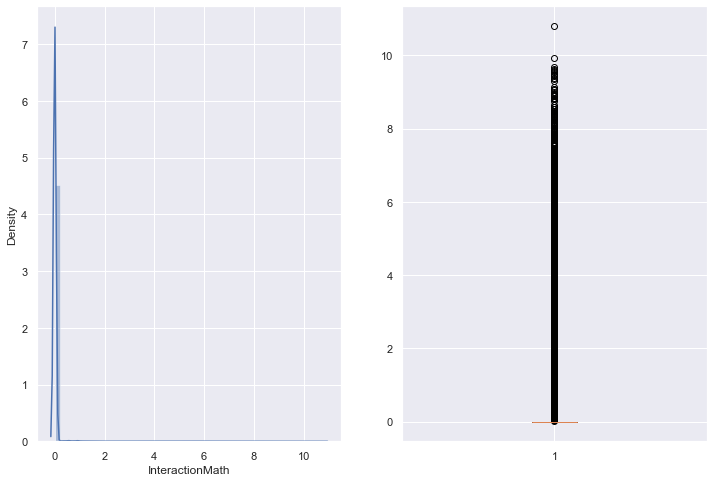


----- InteractionPhonics -----
count    158981.000000
mean          0.077848
std           0.584567
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           9.648775
Name: InteractionPhonics, dtype: float64
* Variance: 0.3417191197978347
* Median: 0.0
* Skewness: 8.735726708069341
* Kurtosis: 82.73513900311829
* Percentage of outliers: 0.023933677609274066
* Number of missing value: 0


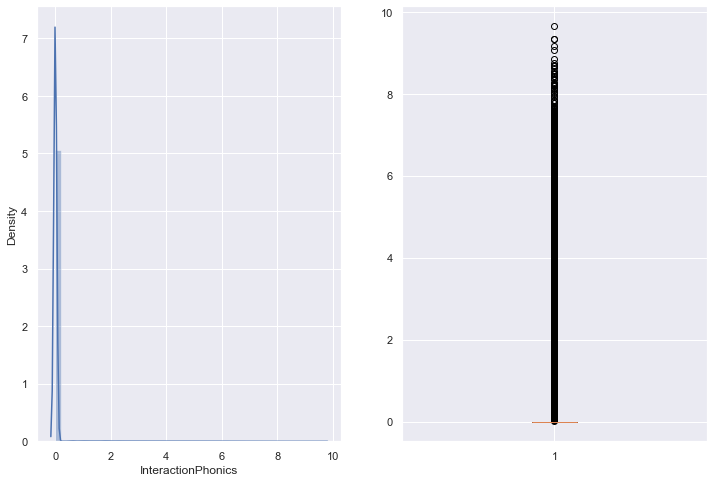


----- InteractionVietnamese -----
count    158981.000000
mean          2.231292
std           2.690476
min           0.000000
25%           0.000000
50%           0.672944
75%           4.466368
max          12.166705
Name: InteractionVietnamese, dtype: float64
* Variance: 7.238658621089571
* Median: 0.6729444732424258
* Skewness: 0.8463501172291487
* Kurtosis: -0.6501800222407272
* Percentage of outliers: 7.548071782162648e-05
* Number of missing value: 0


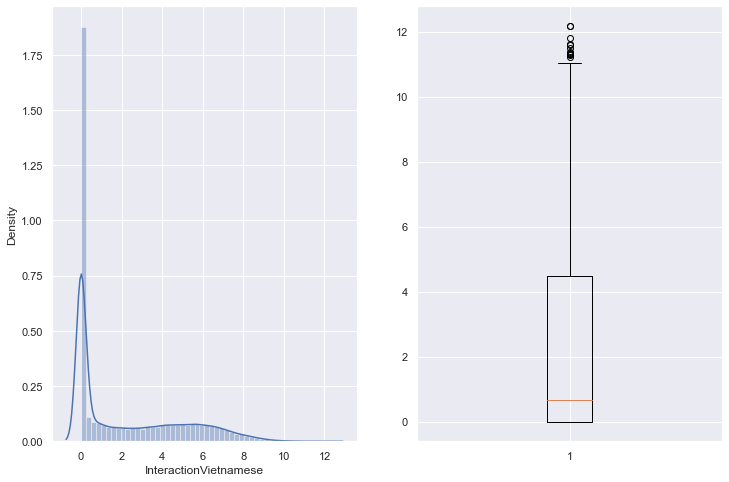


----- IsCompletedEnglish -----
count    158981.000000
mean          0.511774
std           0.576036
min           0.000000
25%           0.000000
50%           0.000000
75%           1.098612
max           1.945910
Name: IsCompletedEnglish, dtype: float64
* Variance: 0.33181772283432764
* Median: 0.0
* Skewness: 0.6273096182977989
* Kurtosis: -0.9177712610441588
* Percentage of outliers: 0.0
* Number of missing value: 0


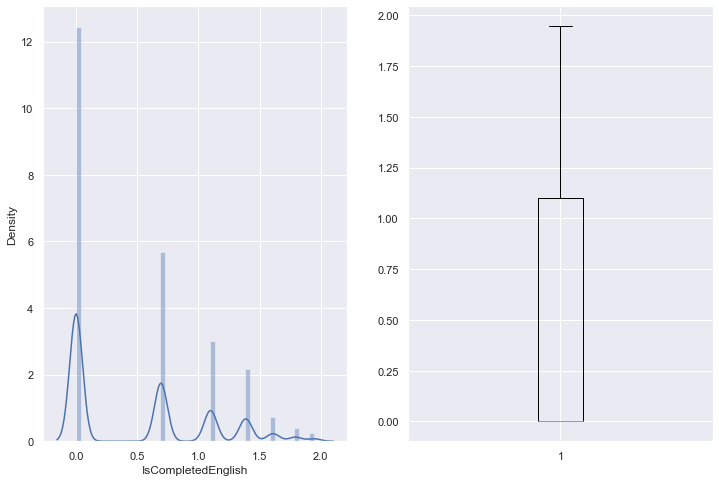


----- IsCompletedMath -----
count    158981.000000
mean          0.020813
std           0.149994
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.945910
Name: IsCompletedMath, dtype: float64
* Variance: 0.02249830347750905
* Median: 0.0
* Skewness: 7.802802776577663
* Kurtosis: 64.2617314472759
* Percentage of outliers: 0.02093331907586441
* Number of missing value: 0


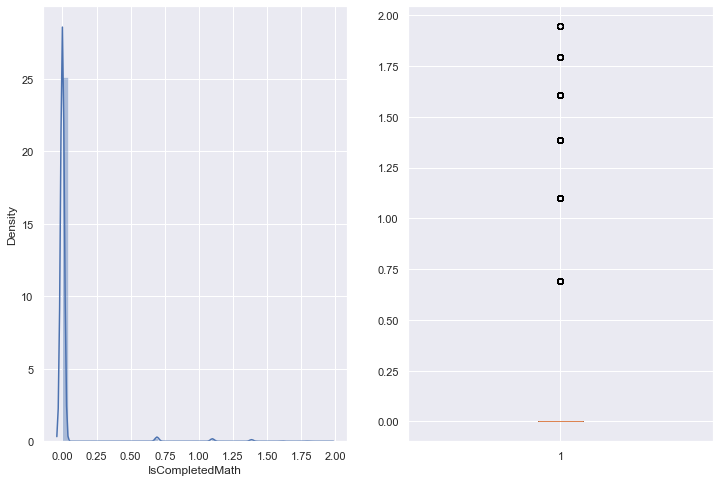


----- IsCompletedPhonics -----
count    158981.000000
mean          0.022953
std           0.162149
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.945910
Name: IsCompletedPhonics, dtype: float64
* Variance: 0.026292236062074224
* Median: 0.0
* Skewness: 7.548587018059829
* Kurtosis: 59.244342244449115
* Percentage of outliers: 0.02161893559607752
* Number of missing value: 0


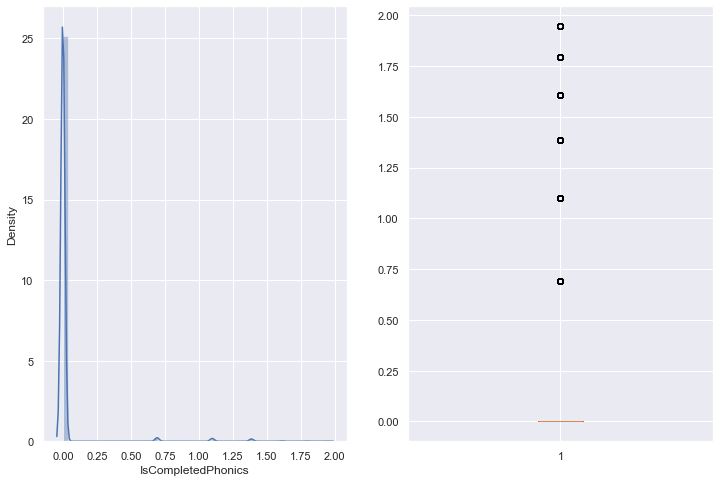


----- IsCompletedVietnamese -----
count    158981.000000
mean          0.530925
std           0.584453
min           0.000000
25%           0.000000
50%           0.693147
75%           1.098612
max           1.945910
Name: IsCompletedVietnamese, dtype: float64
* Variance: 0.3415856410354708
* Median: 0.6931471805599453
* Skewness: 0.5802541608350906
* Kurtosis: -0.9909593564820454
* Percentage of outliers: 0.0
* Number of missing value: 0


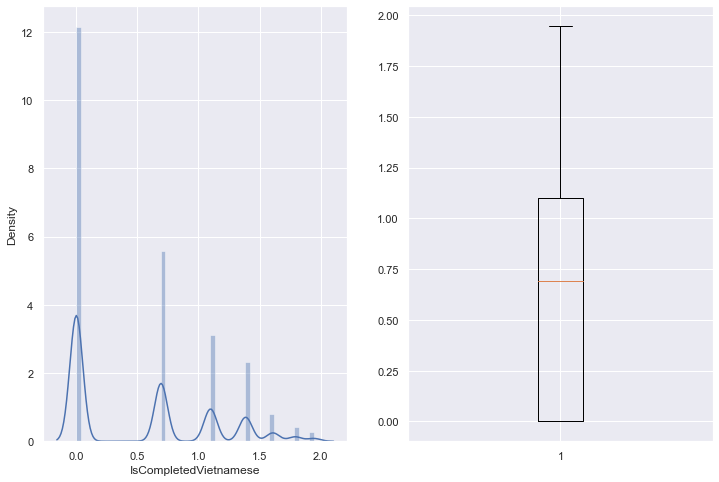


----- RecordEnglish -----
count    158981.000000
mean          1.359019
std           1.553531
min           0.000000
25%           0.000000
50%           0.693147
75%           2.708050
max           6.858565
Name: RecordEnglish, dtype: float64
* Variance: 2.4134596811840345
* Median: 0.6931471805599453
* Skewness: 0.6659957135967302
* Kurtosis: -0.9371496802276607
* Percentage of outliers: 6.290059818468873e-06
* Number of missing value: 0


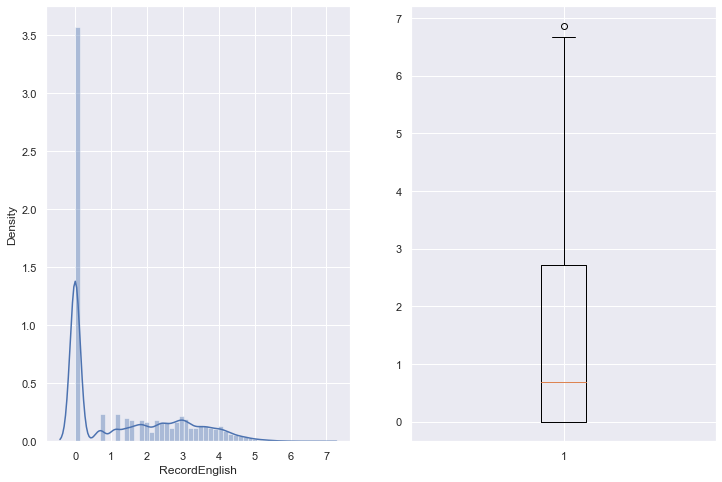


----- RecordMath -----
count    158981.000000
mean          0.049191
std           0.355991
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           5.846439
Name: RecordMath, dtype: float64
* Variance: 0.12672958268298318
* Median: 0.0
* Skewness: 8.212630841554251
* Kurtosis: 72.69380565818504
* Percentage of outliers: 0.023027908995414546
* Number of missing value: 0


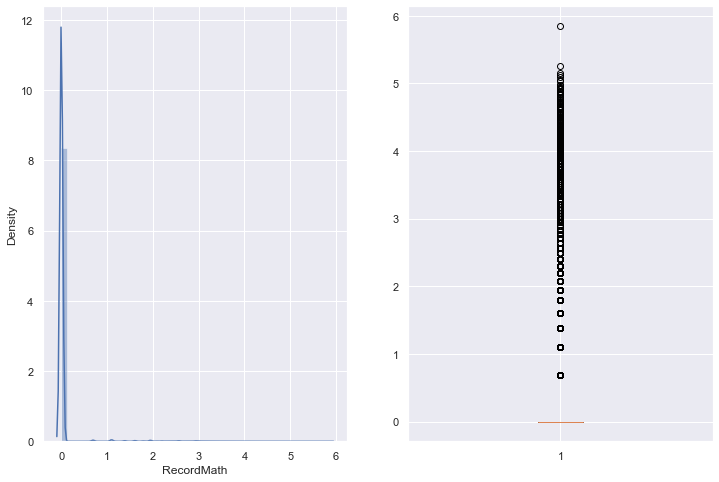


----- RecordPhonics -----
count    158981.000000
mean          0.052982
std           0.370320
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           5.676754
Name: RecordPhonics, dtype: float64
* Variance: 0.13713656837345758
* Median: 0.0
* Skewness: 7.831364722158666
* Kurtosis: 65.78079936882092
* Percentage of outliers: 0.02396512790836641
* Number of missing value: 0


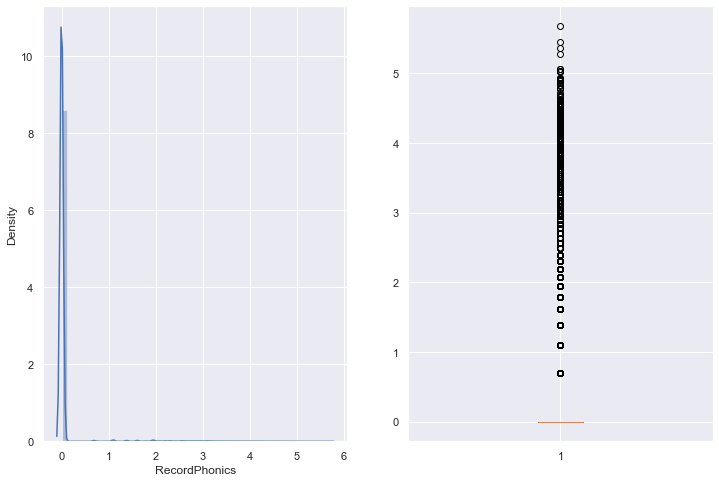


----- RecordVietnamese -----
count    158981.000000
mean          1.406095
std           1.556348
min           0.000000
25%           0.000000
50%           1.098612
75%           2.639057
max           7.151485
Name: RecordVietnamese, dtype: float64
* Variance: 2.422220392924684
* Median: 1.0986122886681098
* Skewness: 0.7088124724170695
* Kurtosis: -0.7618331386741755
* Percentage of outliers: 3.145029909234437e-05
* Number of missing value: 0


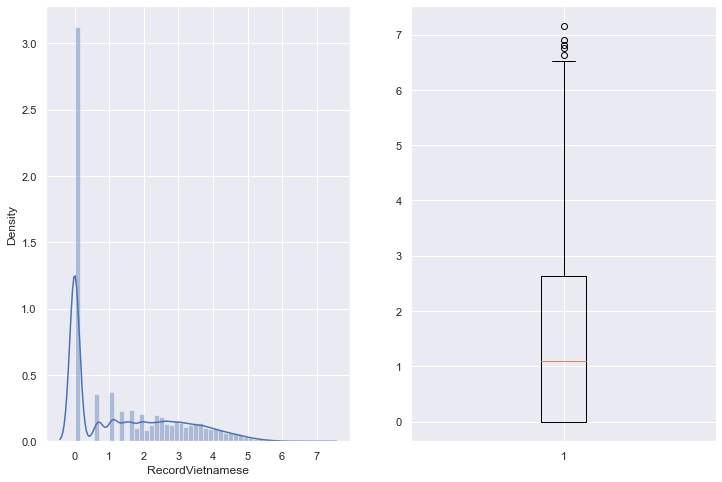


----- UsageTimeEnglish -----
count    158981.000000
mean          1.207146
std           1.428975
min           0.000000
25%           0.000000
50%           0.457425
75%           2.393339
max           7.841485
Name: UsageTimeEnglish, dtype: float64
* Variance: 2.0419701853849785
* Median: 0.4574248470388755
* Skewness: 0.7957742742178726
* Kurtosis: -0.6512341843815896
* Percentage of outliers: 0.0002893427516495682
* Number of missing value: 0


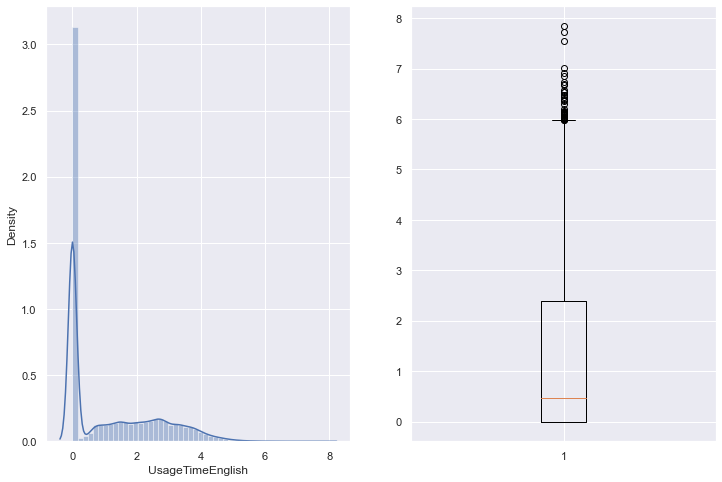


----- UsageTimeMath -----
count    158981.000000
mean          0.042714
std           0.335640
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           6.213808
Name: UsageTimeMath, dtype: float64
* Variance: 0.11265429852556796
* Median: 0.0
* Skewness: 9.335239834038386
* Kurtosis: 95.71944941516334
* Percentage of outliers: 0.02300903881595914
* Number of missing value: 0


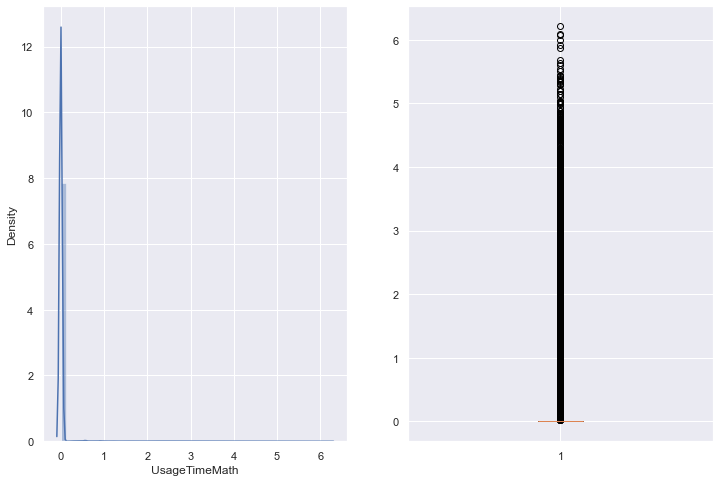


----- UsageTimePhonics -----
count    158981.000000
mean          0.050660
std           0.361165
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           5.554741
Name: UsageTimePhonics, dtype: float64
* Variance: 0.13043988643574986
* Median: 0.0
* Skewness: 8.03149272534671
* Kurtosis: 69.23101477243236
* Percentage of outliers: 0.023933677609274066
* Number of missing value: 0


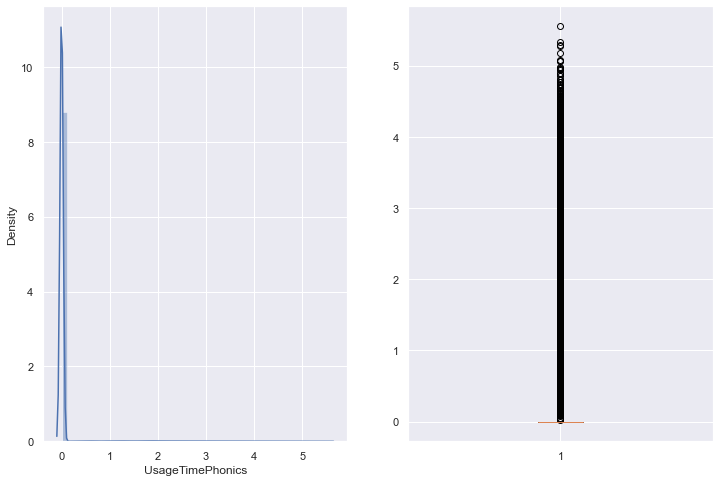


----- UsageTimeVietnamese -----
count    158981.000000
mean          1.323695
std           1.527070
min           0.000000
25%           0.000000
50%           0.615186
75%           2.586259
max           7.317637
Name: UsageTimeVietnamese, dtype: float64
* Variance: 2.331941753527137
* Median: 0.6151856390902335
* Skewness: 0.767501620795993
* Kurtosis: -0.7355349781354819
* Percentage of outliers: 3.145029909234437e-05
* Number of missing value: 0


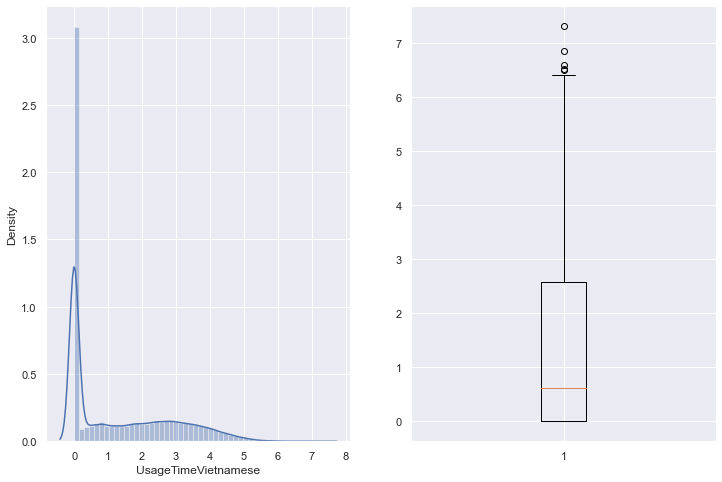


----- RecordDiscovery -----
count    158981.000000
mean          0.631976
std           0.995666
min           0.000000
25%           0.000000
50%           0.000000
75%           1.098612
max           5.583496
Name: RecordDiscovery, dtype: float64
* Variance: 0.9913501852267234
* Median: 0.0
* Skewness: 1.4200703100216872
* Kurtosis: 0.9398257120278517
* Percentage of outliers: 0.05416999515665394
* Number of missing value: 0


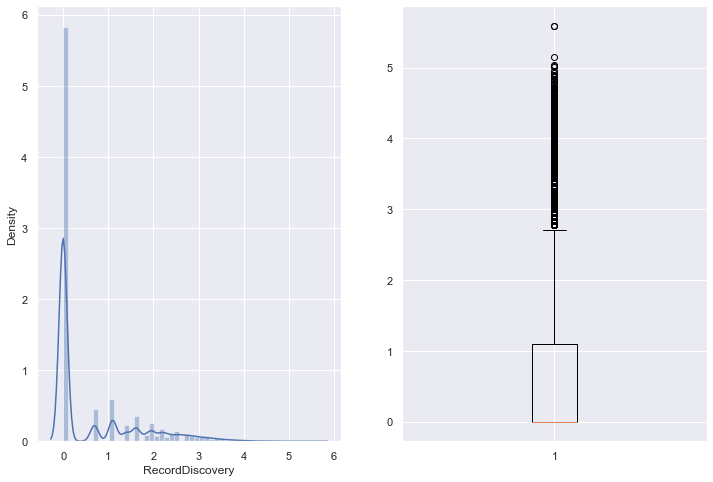


----- RecordEntertainment -----
count    158981.000000
mean          0.715573
std           1.109387
min           0.000000
25%           0.000000
50%           0.000000
75%           1.386294
max           6.248043
Name: RecordEntertainment, dtype: float64
* Variance: 1.2307384904358725
* Median: 0.0
* Skewness: 1.4309016426782737
* Kurtosis: 1.0867751304503588
* Percentage of outliers: 0.02933683899333883
* Number of missing value: 0


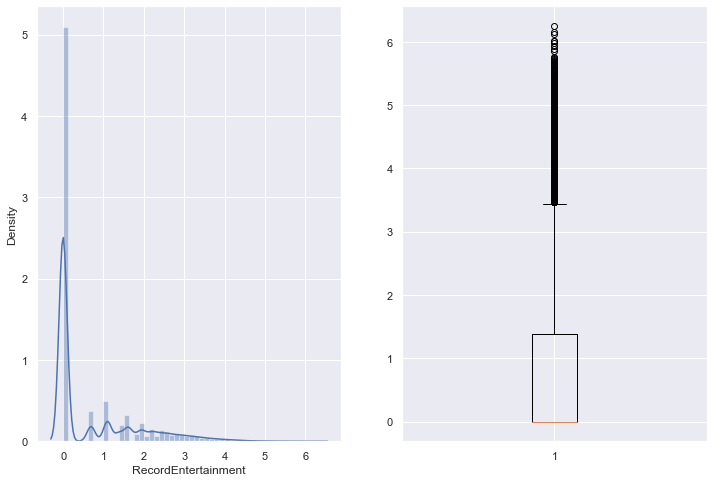


----- RecordLearn -----
count    158981.000000
mean          2.627078
std           1.417644
min           0.000000
25%           1.609438
50%           2.708050
75%           3.713572
max           7.268920
Name: RecordLearn, dtype: float64
* Variance: 2.009715879557398
* Median: 2.70805020110221
* Skewness: -0.02641862662948887
* Kurtosis: -0.7288118019514402
* Percentage of outliers: 0.00012580119636937748
* Number of missing value: 0


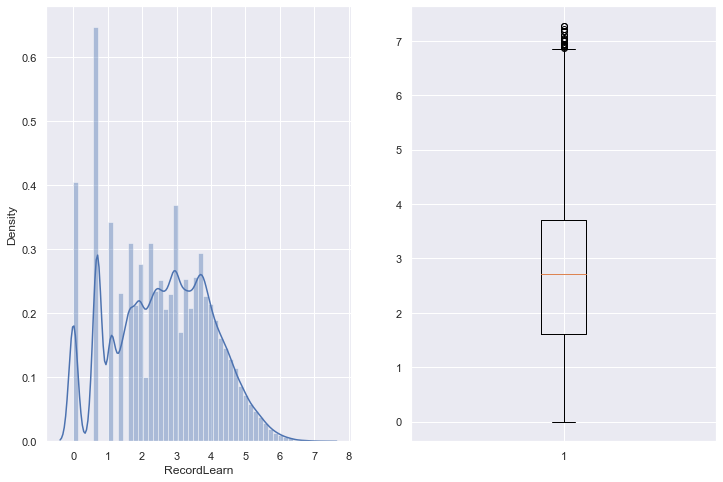


----- UsageTimeDiscovery -----
count    158981.000000
mean          0.794947
std           1.290740
min           0.000000
25%           0.000000
50%           0.000000
75%           1.534714
max           6.162430
Name: UsageTimeDiscovery, dtype: float64
* Variance: 1.6660086317847602
* Median: 0.0
* Skewness: 1.3845432725776041
* Kurtosis: 0.5783462905174122
* Percentage of outliers: 0.03409841427591977
* Number of missing value: 0


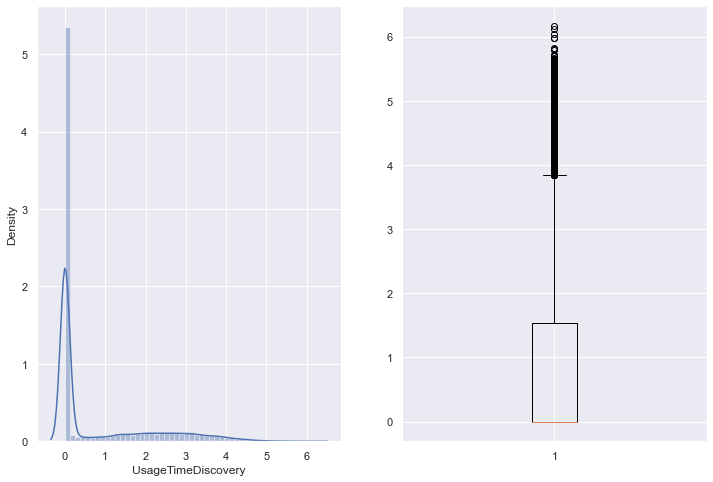


----- UsageTimeEntertainment -----
count    158981.000000
mean          0.771541
std           1.304341
min           0.000000
25%           0.000000
50%           0.000000
75%           1.211941
max           7.381875
Name: UsageTimeEntertainment, dtype: float64
* Variance: 1.7013062224595934
* Median: 0.0
* Skewness: 1.6277398028773744
* Kurtosis: 1.5605143971163433
* Percentage of outliers: 0.09813751328775136
* Number of missing value: 0


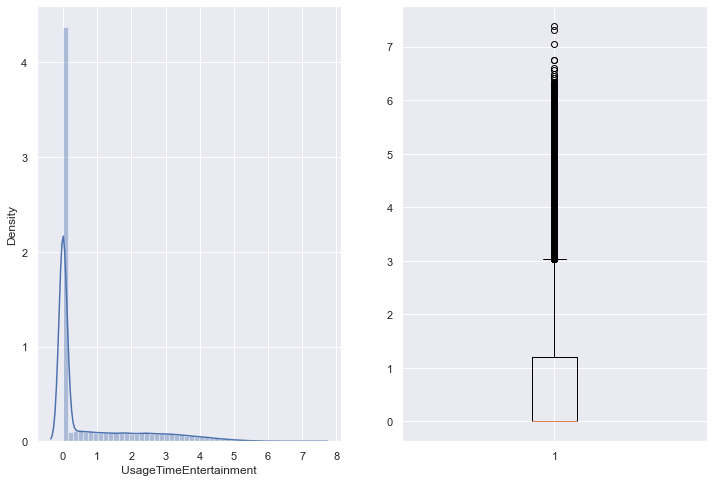


----- UsageTimeLearn -----
count    158981.000000
mean          2.425423
std           1.411968
min           0.000000
25%           1.302913
50%           2.489894
75%           3.490429
max           8.184804
Name: UsageTimeLearn, dtype: float64
* Variance: 1.9936541550038642
* Median: 2.4898941912990393
* Skewness: 0.048371214064368215
* Kurtosis: -0.7771808553103727
* Percentage of outliers: 0.0001698316150986596
* Number of missing value: 0


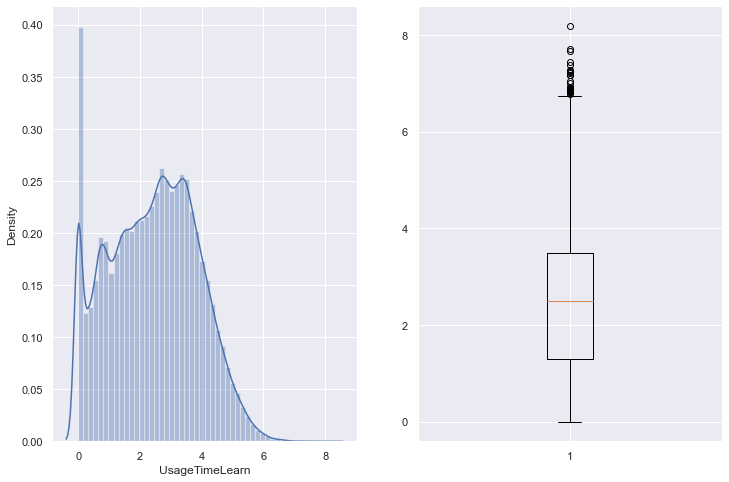


----- MedianUsageTime -----
count    158981.000000
mean          1.891800
std           0.883987
min           0.000000
25%           1.208960
50%           1.922056
75%           2.559550
max           6.095104
Name: MedianUsageTime, dtype: float64
* Variance: 0.7814325575891796
* Median: 1.9220564701759129
* Skewness: 0.031978169276556535
* Kurtosis: -0.6456676694667984
* Percentage of outliers: 0.0006793264603946384
* Number of missing value: 0


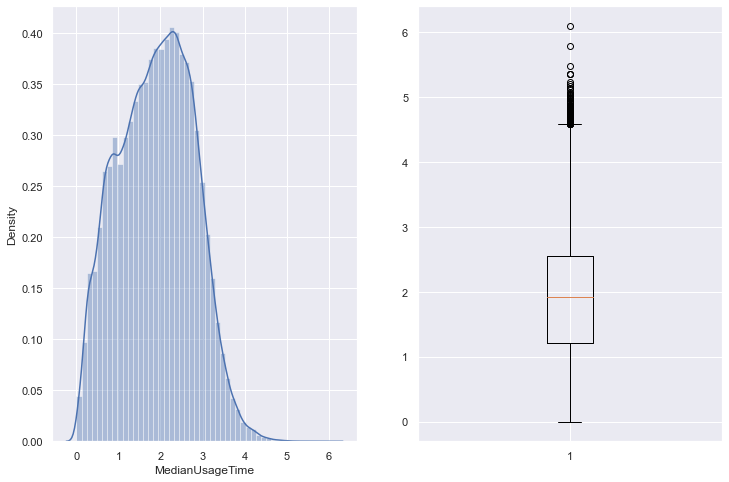


----- MedianRecord -----
count    158981.000000
mean          1.685517
std           0.996566
min           0.000000
25%           1.098612
50%           1.704748
75%           2.397895
max           5.337538
Name: MedianRecord, dtype: float64
* Variance: 0.9931438255690559
* Median: 1.7047480922384253
* Skewness: 0.009331119601694984
* Kurtosis: -0.6693372176066128
* Percentage of outliers: 0.0015159044162509985
* Number of missing value: 0


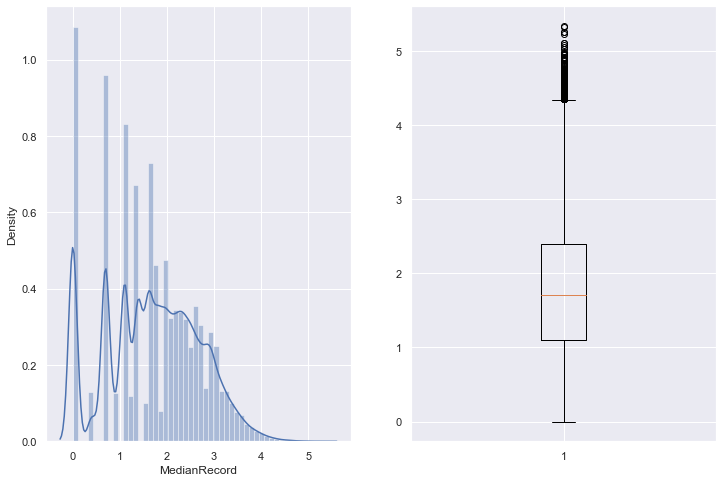


----- MedianPaymentScreen -----
count    158981.000000
mean          0.484424
std           0.704481
min           0.000000
25%           0.000000
50%           0.000000
75%           0.693147
max           5.209486
Name: MedianPaymentScreen, dtype: float64
* Variance: 0.4962935556972138
* Median: 0.0
* Skewness: 1.4307040067187502
* Kurtosis: 1.5454751687173682
* Percentage of outliers: 0.07508444405306294
* Number of missing value: 0


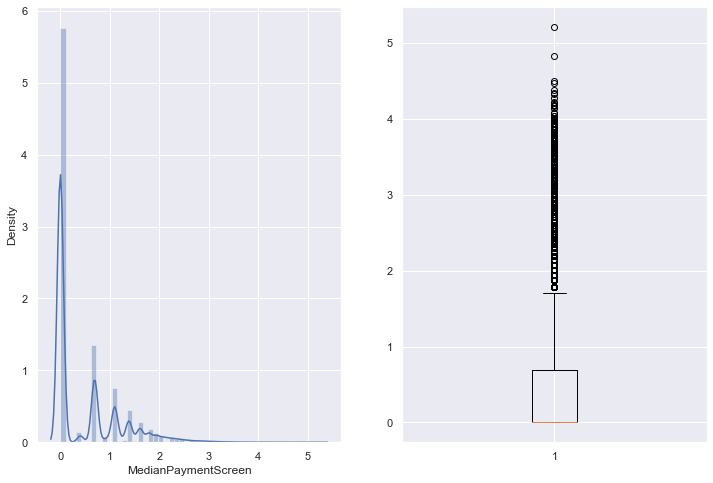


----- AvgTimePerCompletion -----
count    158981.000000
mean          0.668057
std           0.256704
min           0.000000
25%           0.515813
50%           0.624704
75%           0.784317
max           4.224934
Name: AvgTimePerCompletion, dtype: float64
* Variance: 0.06589716620976703
* Median: 0.6247036087297608
* Skewness: 1.2207668438146129
* Kurtosis: 3.8784009039449265
* Percentage of outliers: 0.04736415043307062
* Number of missing value: 0


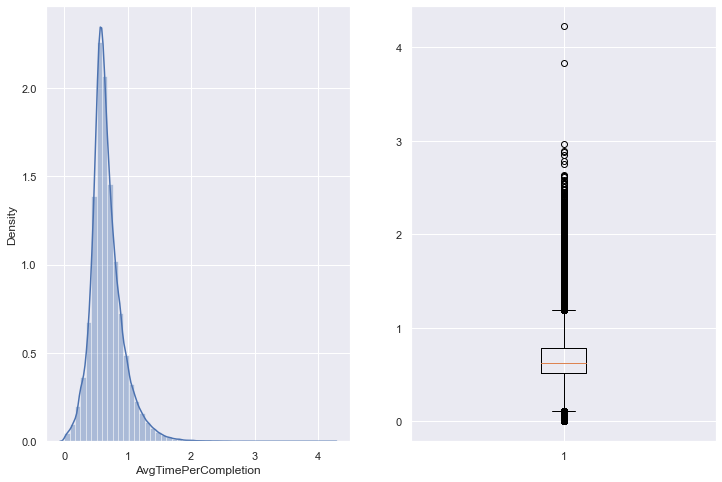


----- InteractionGeneral -----
count    158981.000000
mean          5.502370
std           2.910498
min           0.000000
25%           3.258865
50%           5.673873
75%           7.688455
max          15.362897
Name: InteractionGeneral, dtype: float64
* Variance: 8.47099714585464
* Median: 5.673872944250057
* Skewness: -0.04681017916848819
* Kurtosis: -0.7976454026699473
* Percentage of outliers: 5.0320478547750986e-05
* Number of missing value: 0


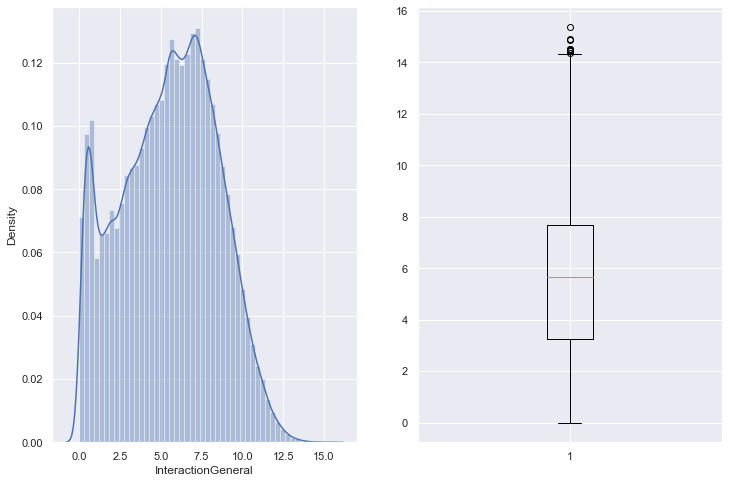


----- Label -----
count    158981.000000
mean          0.064788
std           0.246152
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Label, dtype: float64
* Variance: 0.06059056204465114
* Median: 0.0
* Skewness: 3.5361787763973265
* Kurtosis: 10.504692488772895
* Percentage of outliers: 0.0647876161302294
* Number of missing value: 0


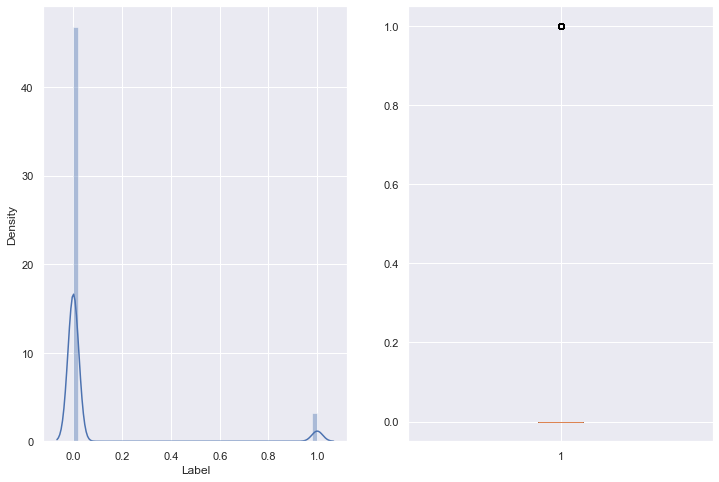

In [106]:
for col in data.columns[1:]:
    fc.continuous_analysis(data, col)

In [107]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158981 entries, 0 to 163039
Data columns (total 42 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   UserID                  158981 non-null  object 
 1   Recency                 158981 non-null  int64  
 2   ContentFrequent         158981 non-null  int64  
 3   PaymentScreenFrequent   158981 non-null  int64  
 4   TotalUsageTime          158981 non-null  float64
 5   TotalRecords            158981 non-null  float64
 6   TotalChild              158981 non-null  float64
 7   MedianChildAge          158981 non-null  float64
 8   No.Female               158981 non-null  float64
 9   No.Male                 158981 non-null  float64
 10  No.TypeBrand            158981 non-null  int64  
 11  BigBrand                158981 non-null  float64
 12  MediumBrand             158981 non-null  float64
 13  SmallBrand              158981 non-null  float64
 14  InteractionEnglish  

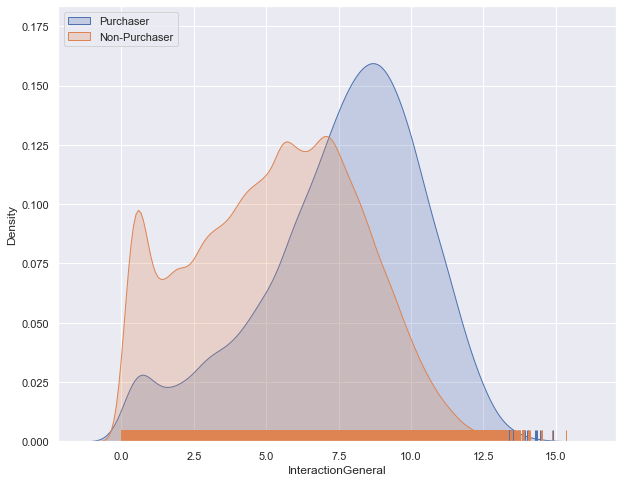

In [109]:
plt.figure(figsize=(10, 8))
sb.distplot(data.loc[data['Label'] == 1]['InteractionGeneral'], label='Purchaser', 
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
sb.distplot(data.loc[data['Label'] == 0]['InteractionGeneral'], label='Non-Purchaser',
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
plt.legend(loc='upper left');

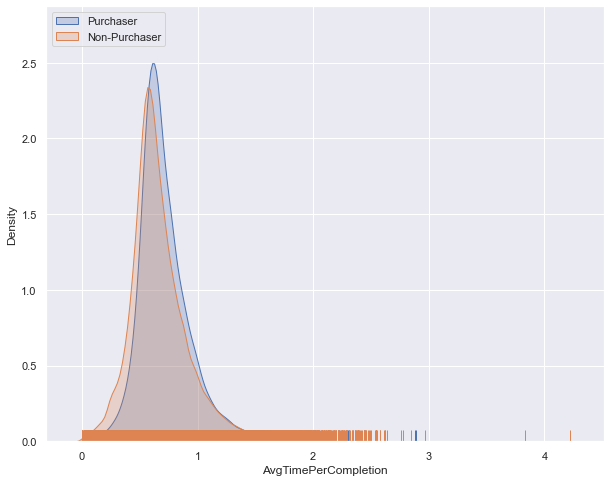

In [112]:
plt.figure(figsize=(10, 8))
sb.distplot(data.loc[data['Label'] == 1]['AvgTimePerCompletion'], label='Purchaser', 
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
sb.distplot(data.loc[data['Label'] == 0]['AvgTimePerCompletion'], label='Non-Purchaser',
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
plt.legend(loc='upper left');

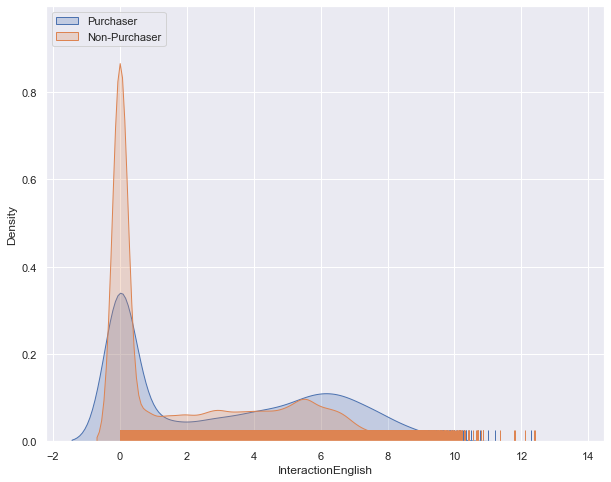

In [114]:
plt.figure(figsize=(10, 8))
sb.distplot(data.loc[data['Label'] == 1]['InteractionEnglish'], label='Purchaser', 
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
sb.distplot(data.loc[data['Label'] == 0]['InteractionEnglish'], label='Non-Purchaser',
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
plt.legend(loc='upper left');

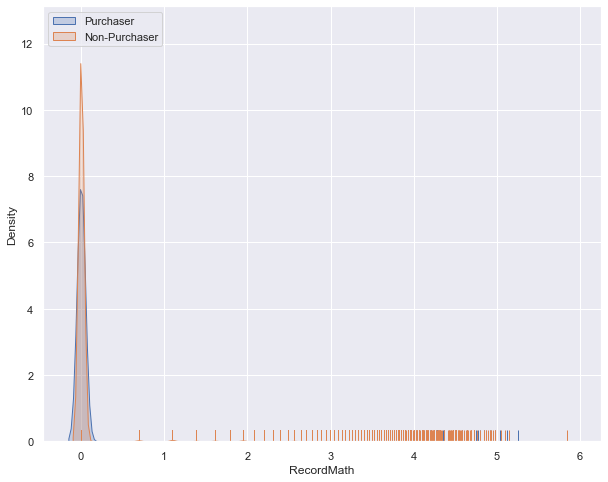

In [117]:
plt.figure(figsize=(10, 8))
sb.distplot(data.loc[data['Label'] == 1]['RecordMath'], label='Purchaser', 
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
sb.distplot(data.loc[data['Label'] == 0]['RecordMath'], label='Non-Purchaser',
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
plt.legend(loc='upper left');

In [115]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158981 entries, 0 to 163039
Data columns (total 42 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   UserID                  158981 non-null  object 
 1   Recency                 158981 non-null  int64  
 2   ContentFrequent         158981 non-null  int64  
 3   PaymentScreenFrequent   158981 non-null  int64  
 4   TotalUsageTime          158981 non-null  float64
 5   TotalRecords            158981 non-null  float64
 6   TotalChild              158981 non-null  float64
 7   MedianChildAge          158981 non-null  float64
 8   No.Female               158981 non-null  float64
 9   No.Male                 158981 non-null  float64
 10  No.TypeBrand            158981 non-null  int64  
 11  BigBrand                158981 non-null  float64
 12  MediumBrand             158981 non-null  float64
 13  SmallBrand              158981 non-null  float64
 14  InteractionEnglish  

In [118]:
data['InteractionLearn'] = data['UsageTimeLearn'] * data['RecordLearn']
data['InteractionDiscovery'] = data['UsageTimeDiscovery'] * data['RecordDiscovery']
data['InteractionEntertainment'] = data['UsageTimeEntertainment'] * data['RecordEntertainment']

In [77]:
# data['ScaledInteractionLearn'] = scaler.fit_transform(data['InteractionLearn'].values.reshape(-1, 1))
# data['ScaledInteractionDiscovery'] = scaler.fit_transform(data['InteractionDiscovery'].values.reshape(-1, 1))
# data['ScaledInteractionEntertainment'] = scaler.fit_transform(data['InteractionEntertainment'].values.reshape(-1, 1))

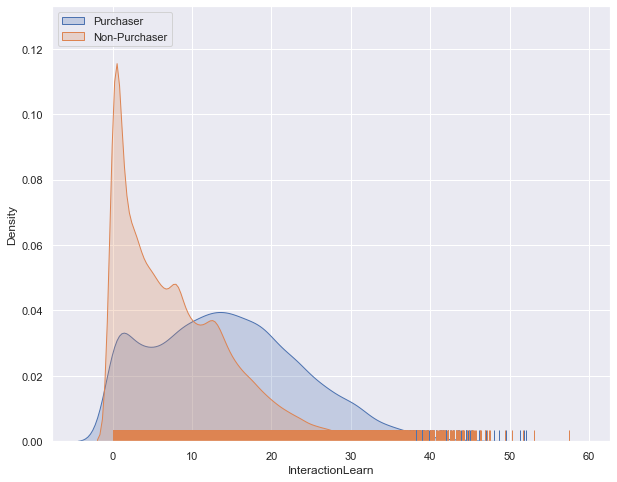

In [121]:
plt.figure(figsize=(10, 8))
sb.distplot(data.loc[data['Label'] == 1]['InteractionLearn'], label='Purchaser', 
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
sb.distplot(data.loc[data['Label'] == 0]['InteractionLearn'], label='Non-Purchaser',
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
plt.legend(loc='upper left');

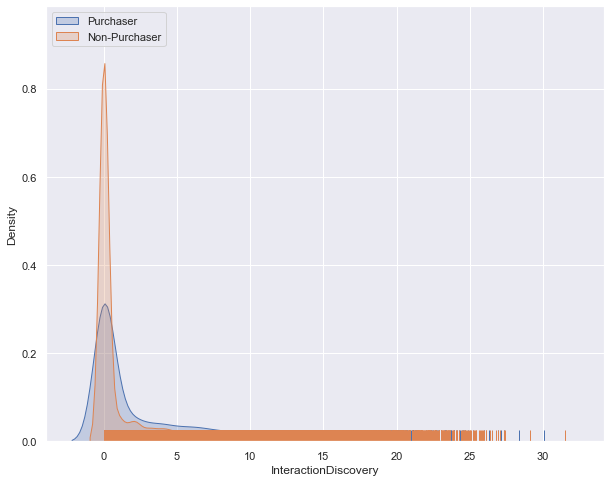

In [122]:
plt.figure(figsize=(10, 8))
sb.distplot(data.loc[data['Label'] == 1]['InteractionDiscovery'], label='Purchaser', 
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
sb.distplot(data.loc[data['Label'] == 0]['InteractionDiscovery'], label='Non-Purchaser',
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
plt.legend(loc='upper left');

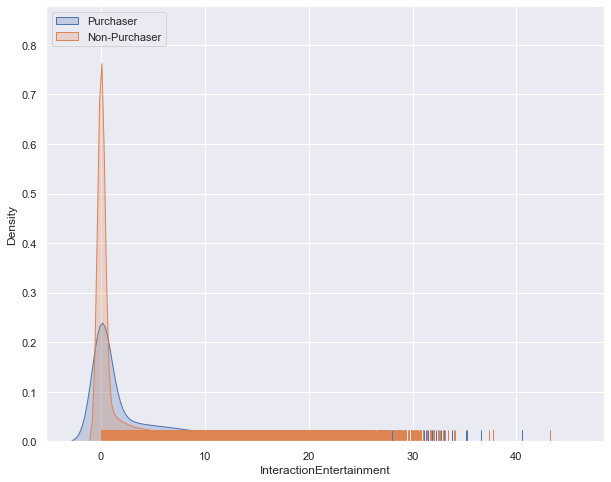

In [123]:
plt.figure(figsize=(10, 8))
sb.distplot(data.loc[data['Label'] == 1]['InteractionEntertainment'], label='Purchaser', 
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
sb.distplot(data.loc[data['Label'] == 0]['InteractionEntertainment'], label='Non-Purchaser',
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
plt.legend(loc='upper left');

In [124]:
data['MedianInteraction'] = data['MedianUsageTime'] * data['MedianRecord']

----- MedianInteraction -----
count    158981.000000
mean          3.954485
std           3.431465
min           0.000000
25%           1.138972
50%           3.210402
75%           6.029054
max          28.301406
Name: MedianInteraction, dtype: float64
* Variance: 11.774953551578452
* Median: 3.210401995568401
* Skewness: 1.0643987534917454
* Kurtosis: 1.2405063084055201
* Percentage of outliers: 0.014668419496669414
* Number of missing value: 0


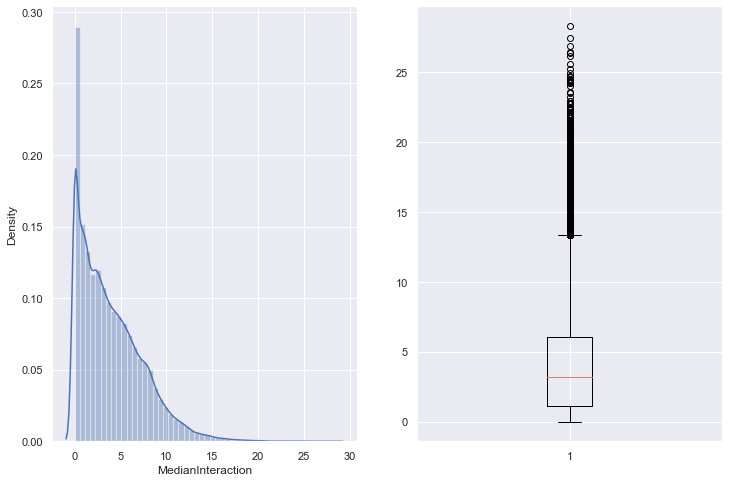

In [125]:
fc.continuous_analysis(data, 'MedianInteraction')

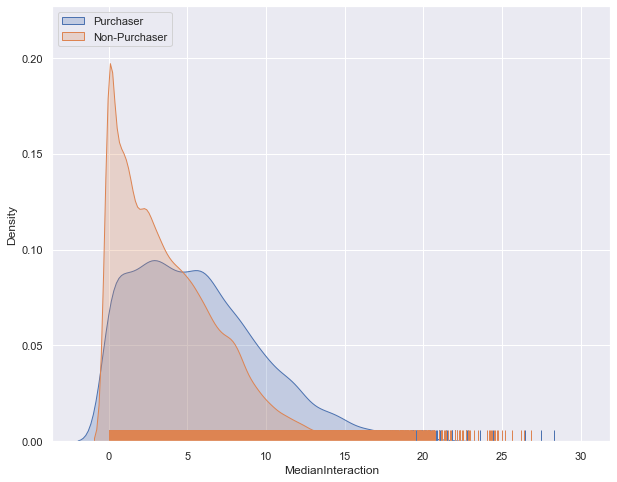

In [126]:
plt.figure(figsize=(10, 8))
sb.distplot(data.loc[data['Label'] == 1]['MedianInteraction'], label='Purchaser', 
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
sb.distplot(data.loc[data['Label'] == 0]['MedianInteraction'], label='Non-Purchaser',
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
plt.legend(loc='upper left');

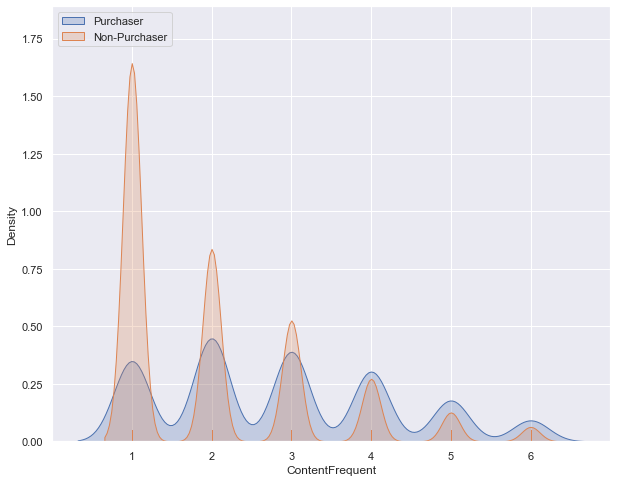

In [91]:
plt.figure(figsize=(10, 8))
sb.distplot(data.loc[data['Label'] == 1]['ContentFrequent'], label='Purchaser', 
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
sb.distplot(data.loc[data['Label'] == 0]['ContentFrequent'], label='Non-Purchaser',
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
plt.legend(loc='upper left');

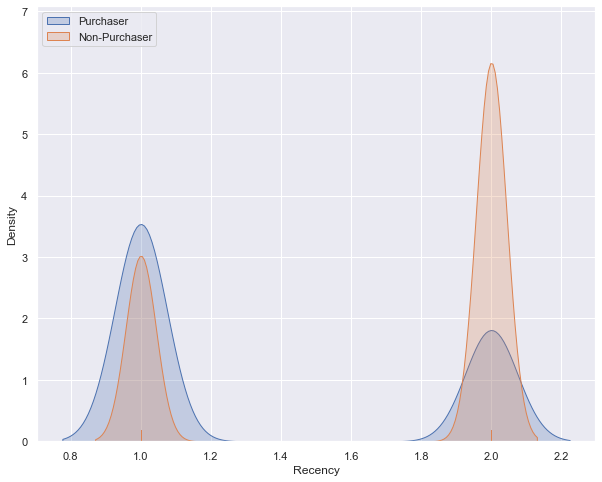

In [92]:
plt.figure(figsize=(10, 8))
sb.distplot(data.loc[data['Label'] == 1]['Recency'], label='Purchaser', 
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
sb.distplot(data.loc[data['Label'] == 0]['Recency'], label='Non-Purchaser',
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
plt.legend(loc='upper left');

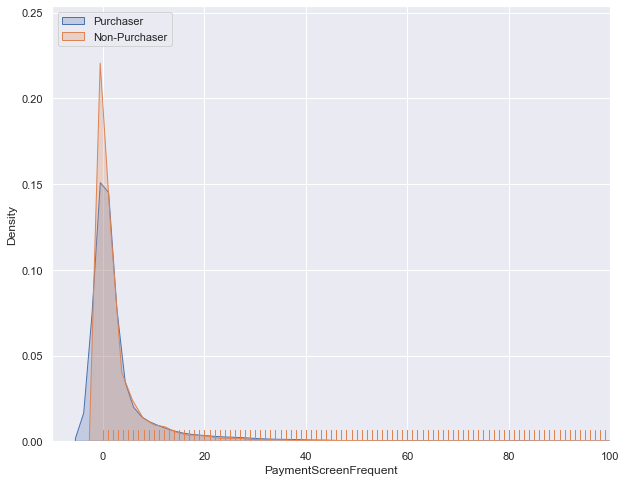

In [164]:
plt.figure(figsize=(10, 8))
sb.distplot(data.loc[data['Label'] == 1]['PaymentScreenFrequent'], label='Purchaser', 
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
sb.distplot(data.loc[data['Label'] == 0]['PaymentScreenFrequent'], label='Non-Purchaser',
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
plt.legend(loc='upper left')
plt.xlim([-10, 100]);

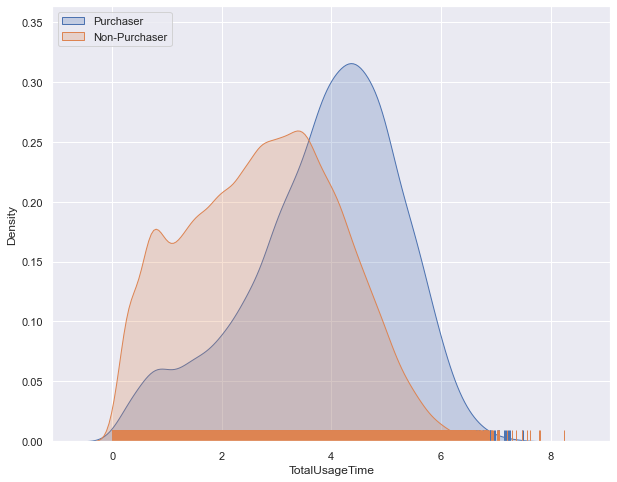

In [127]:
plt.figure(figsize=(10, 8))
sb.distplot(data.loc[data['Label'] == 1]['TotalUsageTime'], label='Purchaser', 
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
sb.distplot(data.loc[data['Label'] == 0]['TotalUsageTime'], label='Non-Purchaser',
            kde_kws={'shade':'kde_kws'},hist = False, rug = True)
plt.legend(loc='upper left');

In [128]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158981 entries, 0 to 163039
Data columns (total 46 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   UserID                    158981 non-null  object 
 1   Recency                   158981 non-null  int64  
 2   ContentFrequent           158981 non-null  int64  
 3   PaymentScreenFrequent     158981 non-null  int64  
 4   TotalUsageTime            158981 non-null  float64
 5   TotalRecords              158981 non-null  float64
 6   TotalChild                158981 non-null  float64
 7   MedianChildAge            158981 non-null  float64
 8   No.Female                 158981 non-null  float64
 9   No.Male                   158981 non-null  float64
 10  No.TypeBrand              158981 non-null  int64  
 11  BigBrand                  158981 non-null  float64
 12  MediumBrand               158981 non-null  float64
 13  SmallBrand                158981 non-null  f

In [129]:
X = data.drop(['UserID', 'Label'], axis = 1)
y = data['Label']

In [130]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [131]:
def ScaleData(train_data, test_data, method=None):
    from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
    if method==None:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    elif method == 'min_max':
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    elif method == 'robust':
        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

In [132]:
X_train_norm, X_test_norm = ScaleData(X_train, X_test, method=None)
X_train_mm, X_test_mm = ScaleData(X_train, X_test, method='min_max')
X_train_rb, X_test_rb = ScaleData(X_train, X_test, method='robust')

In [133]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(random_state = 42)
logit_model = logit.fit(X_train, y_train)

logit_model.score(X_train, y_train)

0.9384749654044534

In [134]:
fc.eval_clf_testset(logit_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9396

* Confusion Matrix: 
[[29654    83]
 [ 1836   224]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     29737
           1       0.73      0.11      0.19      2060

    accuracy                           0.94     31797
   macro avg       0.84      0.55      0.58     31797
weighted avg       0.93      0.94      0.92     31797



In [135]:
logit = LogisticRegression(random_state = 42)
logit_model = logit.fit(X_train_norm, y_train)

logit_model.score(X_train_norm, y_train)

0.9385300037740596

In [136]:
fc.eval_clf_testset(logit_model, X_test_norm, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9394

* Confusion Matrix: 
[[29641    96]
 [ 1832   228]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     29737
           1       0.70      0.11      0.19      2060

    accuracy                           0.94     31797
   macro avg       0.82      0.55      0.58     31797
weighted avg       0.93      0.94      0.92     31797



In [137]:
logit = LogisticRegression(random_state = 42)
logit_model = logit.fit(X_train_mm, y_train)

logit_model.score(X_train_mm, y_train)

0.9384828280286829

In [138]:
fc.eval_clf_testset(logit_model, X_test_mm, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9393

* Confusion Matrix: 
[[29649    88]
 [ 1842   218]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     29737
           1       0.71      0.11      0.18      2060

    accuracy                           0.94     31797
   macro avg       0.83      0.55      0.58     31797
weighted avg       0.93      0.94      0.92     31797



In [139]:
logit = LogisticRegression(random_state = 42)
logit_model = logit.fit(X_train_rb, y_train)

logit_model.score(X_train_rb, y_train)

0.9383727512894704

In [140]:
fc.eval_clf_testset(logit_model, X_test_rb, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9392

* Confusion Matrix: 
[[29641    96]
 [ 1836   224]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     29737
           1       0.70      0.11      0.19      2060

    accuracy                           0.94     31797
   macro avg       0.82      0.55      0.58     31797
weighted avg       0.93      0.94      0.92     31797



In [141]:
import lightgbm as lgbm

lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1500,
                               scale_pos_weight=5,
                               metric='auc')

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9824270348471505

In [142]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.931

* Confusion Matrix: 
[[28937   800]
 [ 1393   667]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     29737
           1       0.45      0.32      0.38      2060

    accuracy                           0.93     31797
   macro avg       0.70      0.65      0.67     31797
weighted avg       0.92      0.93      0.93     31797



ROC AUC score: 0.6484


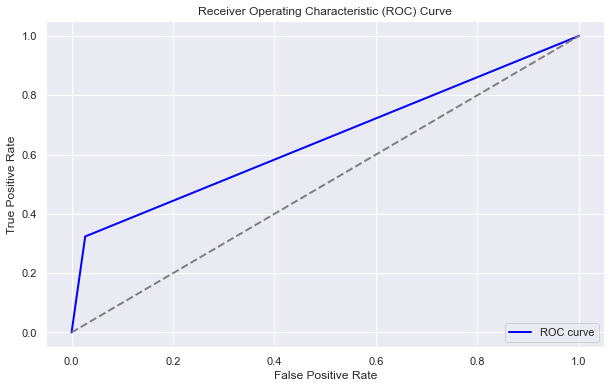

In [143]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [213]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 600,
                               reg_lambda=0.02,
                               scale_pos_weight=15,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.8568137501572525

In [214]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8317

* Confusion Matrix: 
[[25181  4556]
 [  794  1266]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.85      0.90     29737
           1       0.22      0.61      0.32      2060

    accuracy                           0.83     31797
   macro avg       0.59      0.73      0.61     31797
weighted avg       0.92      0.83      0.87     31797



ROC AUC score: 0.7307


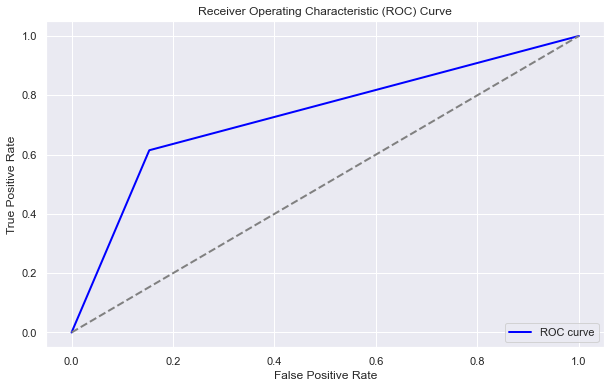

In [215]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [274]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 500,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=5,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=5)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.931367153101019

In [275]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9216

* Confusion Matrix: 
[[28383  1354]
 [ 1140   920]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     29737
           1       0.40      0.45      0.42      2060

    accuracy                           0.92     31797
   macro avg       0.68      0.70      0.69     31797
weighted avg       0.93      0.92      0.92     31797



ROC AUC score: 0.7005


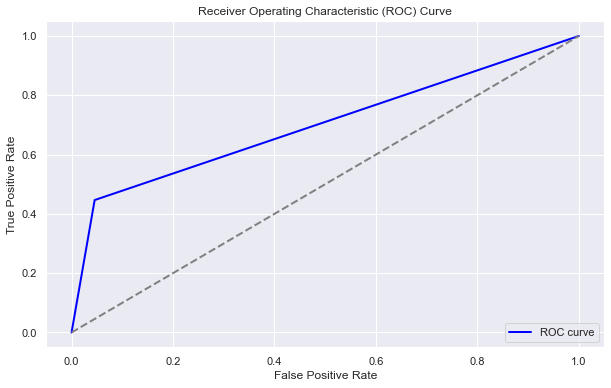

In [276]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [305]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 500,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=5,
                               min_child_weight=1,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=6)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9341819725751667

In [306]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9216

* Confusion Matrix: 
[[28402  1335]
 [ 1159   901]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29737
           1       0.40      0.44      0.42      2060

    accuracy                           0.92     31797
   macro avg       0.68      0.70      0.69     31797
weighted avg       0.92      0.92      0.92     31797



In [ ]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 600,
                            colsample_bytree=0.5646751146007976,
                            learning_rate=0.1419865761603358,
                            max_bin=824,
                            scale_pos_weight=5,
                            min_child_weight=1,
                            reg_alpha=1.6259583347890365e-07,
                            reg_lambda=2.110691851528507e-08,
                            subsample=0.879020578464637,
                            max_depth=2)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

In [150]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1500,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=sum(y_train == 0) / sum(y_train == 1),
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.8,
                               colsample_bytree=0.8)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9207526103912442

In [151]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8756

* Confusion Matrix: 
[[26756  2981]
 [  974  1086]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.90      0.93     29737
           1       0.27      0.53      0.35      2060

    accuracy                           0.88     31797
   macro avg       0.62      0.71      0.64     31797
weighted avg       0.92      0.88      0.89     31797



ROC AUC score: 0.7135


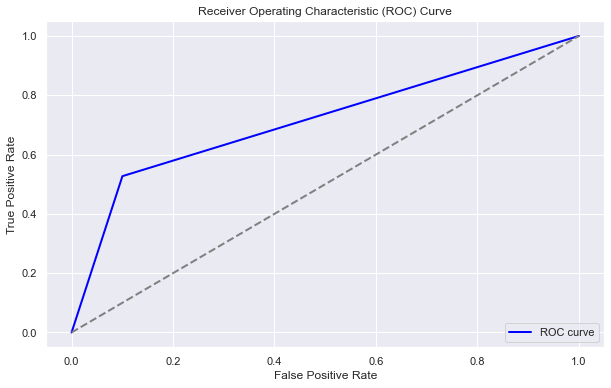

In [152]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [153]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1800,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=5,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85)

lgbm_model = lgbm_clf.fit(X_train_mm, y_train)

lgbm_model.score(X_train_mm, y_train)

0.9705937853818091

In [154]:
fc.eval_clf_testset(lgbm_model, X_test_mm, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9308

* Confusion Matrix: 
[[28846   891]
 [ 1310   750]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     29737
           1       0.46      0.36      0.41      2060

    accuracy                           0.93     31797
   macro avg       0.71      0.67      0.68     31797
weighted avg       0.92      0.93      0.93     31797



ROC AUC score: 0.6671


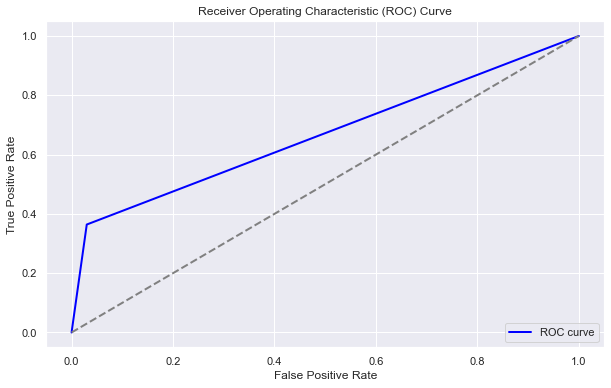

In [155]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test_mm))

In [121]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1500,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=5,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85)

lgbm_model = lgbm_clf.fit(X_train_norm, y_train)

lgbm_model.score(X_train_norm, y_train)

0.9590986287583344

In [122]:
fc.eval_clf_testset(lgbm_model, X_test_norm, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9232

* Confusion Matrix: 
[[28592  1145]
 [ 1296   764]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29737
           1       0.40      0.37      0.38      2060

    accuracy                           0.92     31797
   macro avg       0.68      0.67      0.67     31797
weighted avg       0.92      0.92      0.92     31797



ROC AUC score: 0.6662


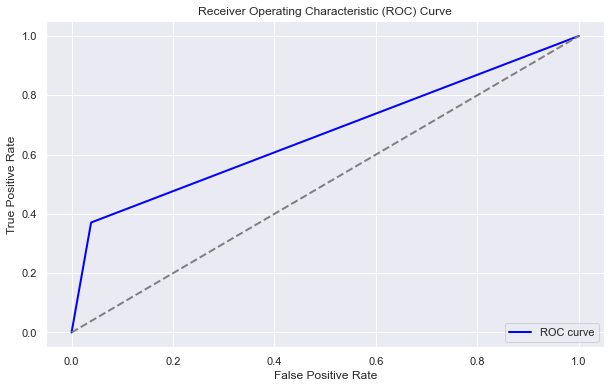

In [123]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test_norm))

In [124]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1500,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=5,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85)

lgbm_model = lgbm_clf.fit(X_train_rb, y_train)

lgbm_model.score(X_train_rb, y_train)

0.9587133601710907

In [125]:
fc.eval_clf_testset(lgbm_model, X_test_rb, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9243

* Confusion Matrix: 
[[28630  1107]
 [ 1301   759]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29737
           1       0.41      0.37      0.39      2060

    accuracy                           0.92     31797
   macro avg       0.68      0.67      0.67     31797
weighted avg       0.92      0.92      0.92     31797



ROC AUC score: 0.6656


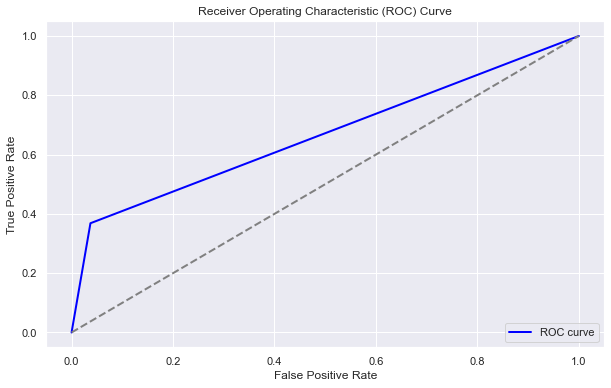

In [126]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test_rb))

In [127]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1500,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=sum(y_train == 0) / sum(y_train == 1),
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85)

lgbm_model = lgbm_clf.fit(X_train_norm, y_train)

lgbm_model.score(X_train_norm, y_train)

0.9052239275380551

In [128]:
fc.eval_clf_testset(lgbm_model, X_test_norm, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8618

* Confusion Matrix: 
[[26305  3432]
 [  962  1098]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.88      0.92     29737
           1       0.24      0.53      0.33      2060

    accuracy                           0.86     31797
   macro avg       0.60      0.71      0.63     31797
weighted avg       0.92      0.86      0.88     31797



ROC AUC score: 0.7088


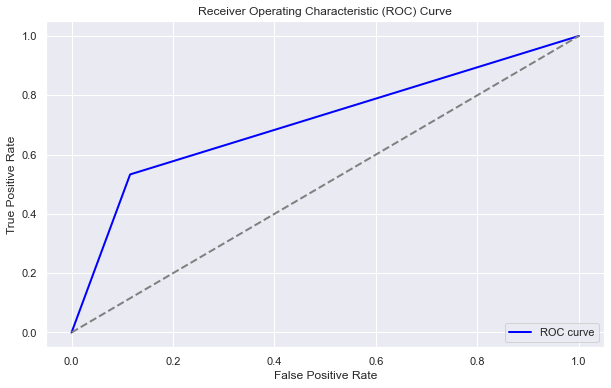

In [129]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test_norm))

In [130]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1500,
                               reg_lambda=0.8,
                               reg_alpha=0.5,
                               scale_pos_weight=sum(y_train == 0) / sum(y_train == 1),
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85)

lgbm_model = lgbm_clf.fit(X_train_norm, y_train)

lgbm_model.score(X_train_norm, y_train)

0.903761479431375

In [131]:
fc.eval_clf_testset(lgbm_model, X_test_norm, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8617

* Confusion Matrix: 
[[26288  3449]
 [  949  1111]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.88      0.92     29737
           1       0.24      0.54      0.34      2060

    accuracy                           0.86     31797
   macro avg       0.60      0.71      0.63     31797
weighted avg       0.92      0.86      0.88     31797



ROC AUC score: 0.7117


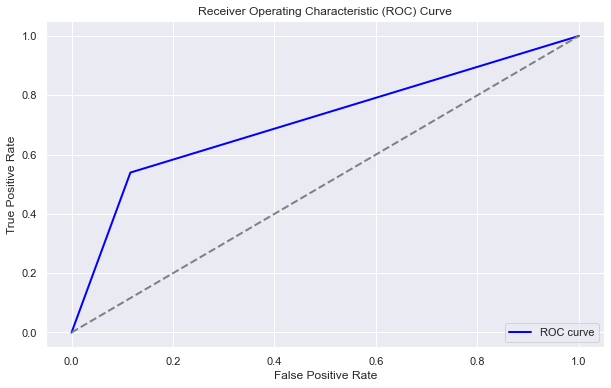

In [132]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test_norm))

In [156]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1800,
                               reg_lambda=0.8,
                               reg_alpha=0.5,
                               scale_pos_weight=6,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9666231601459303

In [157]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9256

* Confusion Matrix: 
[[28623  1114]
 [ 1252   808]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29737
           1       0.42      0.39      0.41      2060

    accuracy                           0.93     31797
   macro avg       0.69      0.68      0.68     31797
weighted avg       0.92      0.93      0.92     31797



ROC AUC score: 0.6774


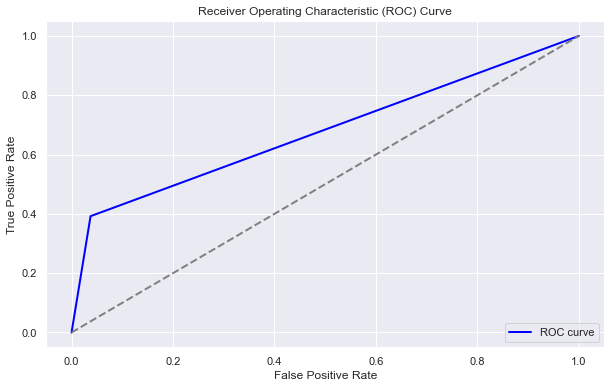

In [158]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [159]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1800,
                               reg_lambda=1,
                               reg_alpha=0.8,
                               scale_pos_weight=5.5,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.965105673669644

In [160]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9231

* Confusion Matrix: 
[[28518  1219]
 [ 1226   834]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29737
           1       0.41      0.40      0.41      2060

    accuracy                           0.92     31797
   macro avg       0.68      0.68      0.68     31797
weighted avg       0.92      0.92      0.92     31797



ROC AUC score: 0.6819


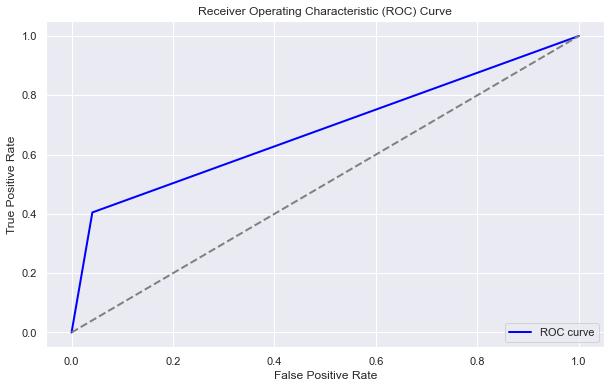

In [161]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [162]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1800,
                               reg_lambda=0.8,
                               reg_alpha=0.5,
                               scale_pos_weight=15,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9281985155365455

In [163]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8792

* Confusion Matrix: 
[[26909  2828]
 [ 1013  1047]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.90      0.93     29737
           1       0.27      0.51      0.35      2060

    accuracy                           0.88     31797
   macro avg       0.62      0.71      0.64     31797
weighted avg       0.92      0.88      0.90     31797



ROC AUC score: 0.7066


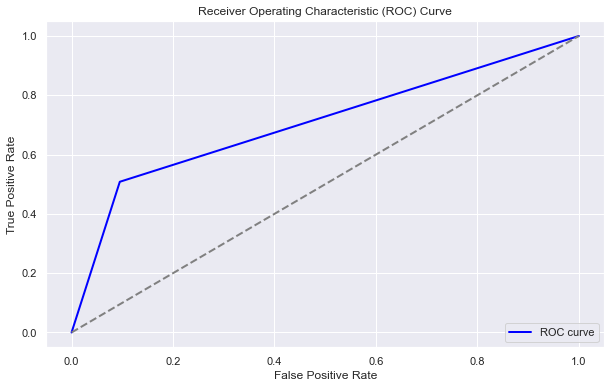

In [164]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [165]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1800,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=15,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9305022644357781

In [166]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8808

* Confusion Matrix: 
[[26963  2774]
 [ 1016  1044]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.91      0.93     29737
           1       0.27      0.51      0.36      2060

    accuracy                           0.88     31797
   macro avg       0.62      0.71      0.64     31797
weighted avg       0.92      0.88      0.90     31797



ROC AUC score: 0.7068


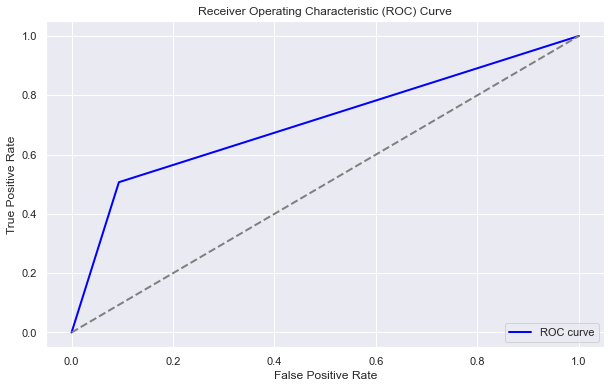

In [167]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [231]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 600,
                            colsample_bytree=0.5646751146007976,
                            learning_rate=0.1419865761603358,
                            max_bin=824,
                            scale_pos_weight=5.5,
                            min_child_weight=1,
                            reg_alpha=1.6259583347890365e-07,
                            reg_lambda=2.110691851528507e-08,
                            subsample=0.879020578464637,
                            max_depth=2,
                            n_jobs=-1)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.912339602465719

In [232]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9105

* Confusion Matrix: 
[[27974  1763]
 [ 1083   977]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     29737
           1       0.36      0.47      0.41      2060

    accuracy                           0.91     31797
   macro avg       0.66      0.71      0.68     31797
weighted avg       0.92      0.91      0.92     31797



ROC AUC score: 0.7075


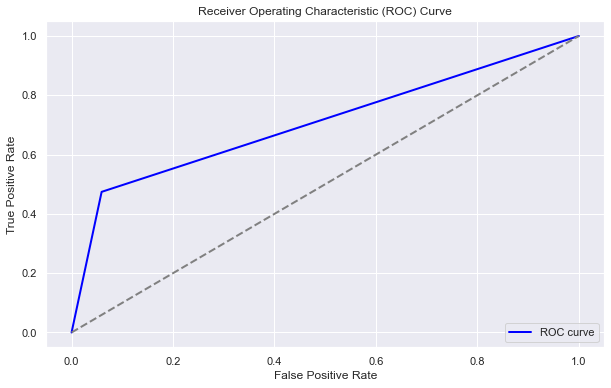

In [233]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [234]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 600,
                            colsample_bytree=0.5646751146007976,
                            learning_rate=0.1419865761603358,
                            max_bin=824,
                            scale_pos_weight=15,
                            min_child_weight=1,
                            reg_alpha=1.6259583347890365e-07,
                            reg_lambda=2.110691851528507e-08,
                            subsample=0.879020578464637,
                            max_depth=2,
                            n_jobs=-1)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.7914596175619575

In [235]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.7861

* Confusion Matrix: 
[[23606  6131]
 [  669  1391]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.79      0.87     29737
           1       0.18      0.68      0.29      2060

    accuracy                           0.79     31797
   macro avg       0.58      0.73      0.58     31797
weighted avg       0.92      0.79      0.84     31797



ROC AUC score: 0.7345


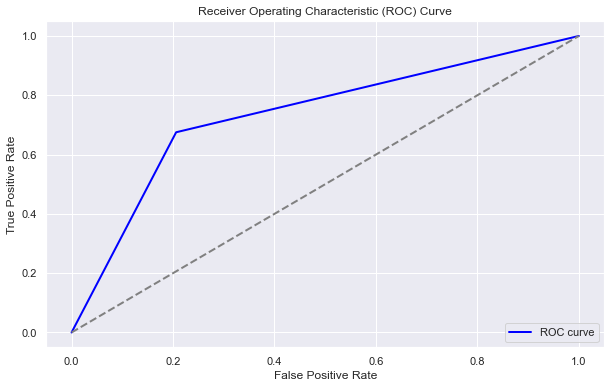

In [236]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [168]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(random_state=42)
xgb_model = xgb_clf.fit(X_train, y_train)

xgb_model.score(X_train, y_train)

0.952957919235124

In [169]:
fc.eval_clf_testset(xgb_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9421

* Confusion Matrix: 
[[29567   170]
 [ 1670   390]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     29737
           1       0.70      0.19      0.30      2060

    accuracy                           0.94     31797
   macro avg       0.82      0.59      0.63     31797
weighted avg       0.93      0.94      0.93     31797



ROC AUC score: 0.5918


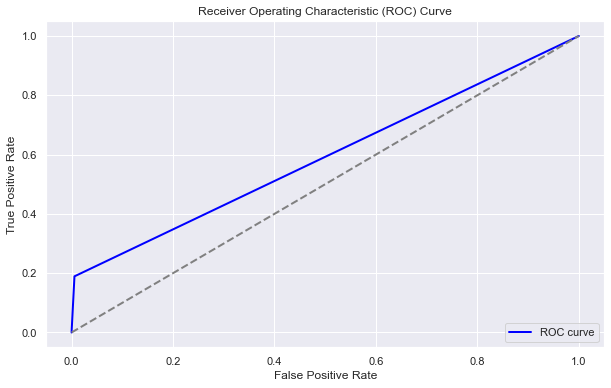

In [170]:
fc.plot_roc_curve(y_test, xgb_model.predict(X_test))

In [171]:
xgb_clf = xgb.XGBClassifier(random_state=42, 
                            objective= 'binary:logistic',
                            scale_pos_weight=sum(y_train == 0) / sum(y_train == 1),
                            max_depth=8,
                            min_child_weight=10,
                            subsample=0.8,
                            colsample_bytree=0.85,
                            learning_rate=0.05)
xgb_model = xgb_clf.fit(X_train, y_train)

xgb_model.score(X_train, y_train)

0.8403965907661342

In [172]:
fc.eval_clf_testset(xgb_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8272

* Confusion Matrix: 
[[24987  4750]
 [  745  1315]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.84      0.90     29737
           1       0.22      0.64      0.32      2060

    accuracy                           0.83     31797
   macro avg       0.59      0.74      0.61     31797
weighted avg       0.92      0.83      0.86     31797



ROC AUC score: 0.7393


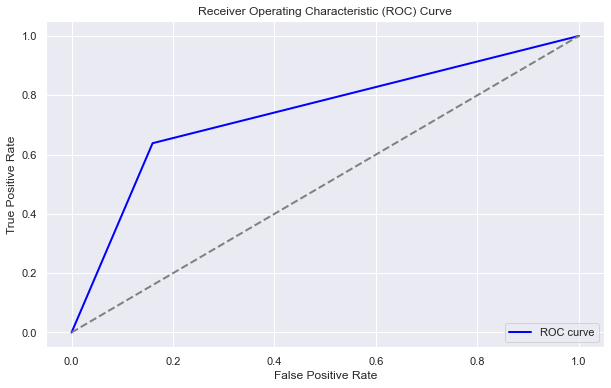

In [173]:
fc.plot_roc_curve(y_test, xgb_model.predict(X_test))

In [188]:
xgb_clf = xgb.XGBClassifier(random_state = 42, n_estimators = 900,
                            colsample_bytree=0.5646751146007976,
                            learning_rate=0.1419865761603358,
                            max_bin=824,
                            scale_pos_weight=5,
                            min_child_weight=1,
                            reg_alpha=1.6259583347890365e-07,
                            reg_lambda=2.110691851528507e-08,
                            subsample=0.879020578464637,
                            objective='binary:logistic',
                            max_depth=3,
                            n_jobs=-1,
                            verbosity=0)

xgb_model = xgb_clf.fit(X_train, y_train)
xgb_model.score(X_train, y_train)

0.9302978362058121

In [189]:
fc.eval_clf_testset(xgb_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9189

* Confusion Matrix: 
[[28310  1427]
 [ 1152   908]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     29737
           1       0.39      0.44      0.41      2060

    accuracy                           0.92     31797
   macro avg       0.67      0.70      0.68     31797
weighted avg       0.92      0.92      0.92     31797



ROC AUC score: 0.6964


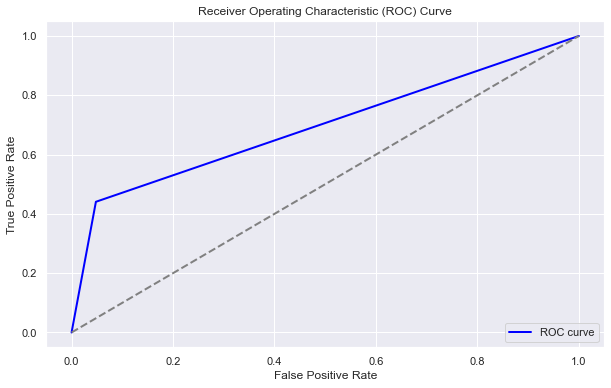

In [190]:
fc.plot_roc_curve(y_test, xgb_model.predict(X_test))

In [148]:
xgb_clf = xgb.XGBClassifier(random_state = 42, n_estimators = 1500,
                               reg_lambda=0.8,
                               reg_alpha=0.5,
                               scale_pos_weight=15,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85)

xgb_model = xgb_clf.fit(X_train, y_train)

xgb_model.score(X_train, y_train)

0.9196203925022015

In [149]:
fc.eval_clf_testset(xgb_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.867

* Confusion Matrix: 
[[26524  3213]
 [ 1017  1043]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.89      0.93     29737
           1       0.25      0.51      0.33      2060

    accuracy                           0.87     31797
   macro avg       0.60      0.70      0.63     31797
weighted avg       0.92      0.87      0.89     31797



ROC AUC score: 0.6991


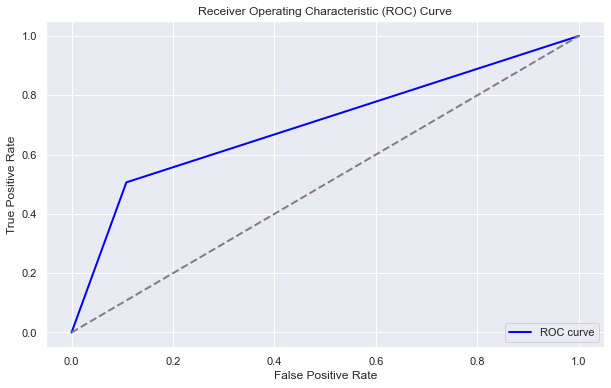

In [150]:
fc.plot_roc_curve(y_test, xgb_model.predict(X_test))

In [174]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42, sampling_strategy='minority')

X_train_rs, y_train_rs = sm.fit_resample(X_train, y_train)

In [175]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1500,
                               scale_pos_weight=5)

lgbm_model = lgbm_clf.fit(X_train_rs, y_train_rs)

lgbm_model.score(X_train_rs, y_train_rs)

0.9830214218455744

In [176]:
fc.eval_clf_testset(lgbm_model, X_train, y_train)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9688

* Confusion Matrix: 
[[116157   2787]
 [  1175   7065]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.98      0.98    118944
           1       0.72      0.86      0.78      8240

    accuracy                           0.97    127184
   macro avg       0.85      0.92      0.88    127184
weighted avg       0.97      0.97      0.97    127184



In [177]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9165

* Confusion Matrix: 
[[28391  1346]
 [ 1309   751]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     29737
           1       0.36      0.36      0.36      2060

    accuracy                           0.92     31797
   macro avg       0.66      0.66      0.66     31797
weighted avg       0.92      0.92      0.92     31797



ROC AUC score: 0.6596


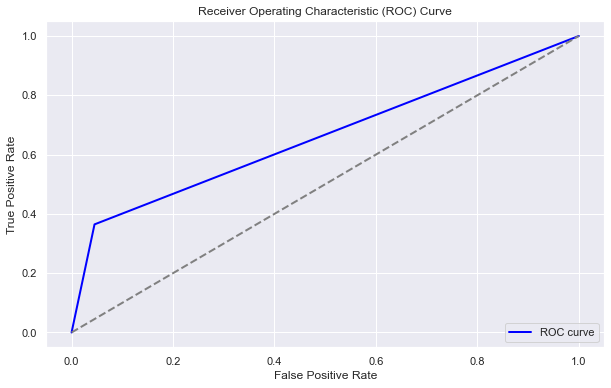

In [178]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [179]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1500,
                               reg_lambda=0.8,
                               reg_alpha=0.5,
                               scale_pos_weight=5,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85)

lgbm_model = lgbm_clf.fit(X_train_rs, y_train_rs)

lgbm_model.score(X_train_rs, y_train_rs)

0.9667238364272263

In [180]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9067

* Confusion Matrix: 
[[27948  1789]
 [ 1178   882]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     29737
           1       0.33      0.43      0.37      2060

    accuracy                           0.91     31797
   macro avg       0.64      0.68      0.66     31797
weighted avg       0.92      0.91      0.91     31797



ROC AUC score: 0.6840


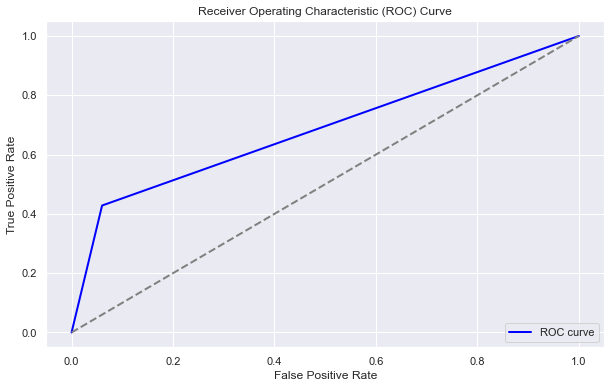

In [181]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [161]:
data.to_csv('DataFeatureTransformed.csv', index=False)